In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_5_mean_cluster_atmos
from funzioni import plot_5_mean_cluster_tos
from funzioni import plot_5_mean_cluster_zonmean
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D
from scipy import stats
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

Caricamento dei file pickle

In [25]:
# Caricamento di models e models_atmos
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)   
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)

    #Caricamento dei cluster standard deviation in formato pdf
    atmos_cluster0_std = pickle.load(f)
    atmos_cluster1_std = pickle.load(f)
    atmos_cluster2_std = pickle.load(f)
    atmos_cluster3_std = pickle.load(f)

In [26]:
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)
     
with open('models_zonmean.pkl','rb') as file:
    models_zonmean = dill.load(file)
    era_seas_mean = dill.load(file)

Clustering su zonal wind bias

In [27]:
#Riduco la latitudine a (30,80)
#for name in models_atmos.keys():
#    era_na_seas_mean[4] = era_na_seas_mean[4].sel(lat=slice(30,80))
#    models_atmos[name]['atmos North Atlantic seasonal mean DJF'] = models_atmos[name]['atmos North Atlantic seasonal mean DJF'].sel(lat=slice(30,80))
#    models_atmos[name]['atmos North Atlantic bias DJF'] = models_atmos[name]['atmos North Atlantic bias DJF'].sel(lat=slice(30,80))

Creo la feature matrix con dimensioni = (35,25x78)

In [28]:
n_rows = len(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lat.values) # prendo un modello generico e calcolo il numero di righe, pari al numero di grid cell sulla latitudine
n_cols = len(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lon.values) #il numero di colonne è pari al numero di grid cell sulla longitudine
n_elements = n_rows * n_cols
n_models = len(models_atmos) # numero di modelli

In [29]:
np_array_models_2d = np.zeros((n_rows,n_cols)) #inizializzazione array 2-dim, che ha sulle colonne la longitudine e sulle righe la latitudine e andrò a mettere i valori dei bias di temperatura della stagione MAM
np_array_models_1d = np.zeros(n_elements) #inizializzazione array 1-dim, creato con righe di np_array_models_2d messe una accanto all'altra
feature_matrix_init = np.zeros((n_models,n_elements)) #inizializzazione matrice con righe pari al numero di modelli e per ogni riga vado a mettere 
i = 0 #inizializzazione indice righe feature_matrix_init
feature_matrix_init.shape

(35, 2340)

In [30]:
for name in models_atmos.keys(): #models_list è una lista contenente il nome di tutti i modelli che sto utilizzando. Quindi ciclo sul numero dei modelli
    #Creo array
    np_array_models_2d = models_atmos[name]['atmos North Atlantic bias DJF'].values #estraggo i valori da bias MAM e li metto in un array 2d, dove sulle righe c'è la latitudine e sulle colonne la longitudine
    np_array_models_1d = np_array_models_2d.flatten() #array 1d con numero di elementi pari a lat x lon (messe una accanto all'altra le righe dell'array 2d precedente)
    #Creo feature matrix
    feature_matrix_init[i,:] = np_array_models_1d #ogni riga di feature_matrix_init è pari a np_array_models_1d
    i = i + 1 #aggiorno indice i

feature_matrix_init.shape

(35, 2340)

Elimino le colonne contenenti 'nan'

In [31]:
#Elimino le colonne che contengono almeno un nan e creo la feature_matrix
feature_matrix = np.empty((n_models,0)) #inizializzo la nuova feature matrix, cioè la matrice senza nan
number_nan = 0 #inizializzo il numero dei number nan
arr = np.zeros(n_models) #inizializzo array di dimensione pari al numero di modelli
cell_grid_nan = [] #lista vuota che contiene il numero delle celle della griglia che hanno elementi nan e che quindi vengono eliminate per il calcolo di feature_matrix

for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init   
    if np.isnan(feature_matrix_init[:,j]).any(): #se c'è almeno un elemento nan all'interno della colonna
        cell_grid_nan.append(j) #costruisco la cella con il numero delle colonne che contengono elementi nan
        number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
    else: #se la colonna non contiene nan
        arr = feature_matrix_init[:,j]
        feature_matrix = np.column_stack((feature_matrix,arr)) #aggiungo la colonna di feature_matrix_init senza nan alla matrice feature_matrix
    

In [32]:
print(cell_grid_nan)

[10, 11, 12, 88, 89, 165, 166, 167, 243, 320, 321, 476, 550, 551, 552, 553, 554, 555, 556, 557, 627, 628, 629, 630, 631, 632, 633, 634, 635, 705, 706, 707, 708, 709, 710, 711, 712, 713, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 861, 862, 863, 864, 865, 866, 867, 868, 869, 940, 941, 942, 943, 944, 945, 1174, 1677, 1678, 1754, 1755, 1756, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303,

In [33]:
len(cell_grid_nan)

187

In [34]:
feature_matrix.shape

(35, 2153)

Elimino le colonne contenenti 'nan'

In [35]:
#Elimino le colonne che contengono almeno un nan e creo la feature_matrix
feature_matrix = np.empty((n_models,0)) #inizializzo la nuova feature matrix, cioè la matrice senza nan
number_nan = 0 #inizializzo il numero dei number nan
arr = np.zeros(n_models) #inizializzo array di dimensione pari al numero di modelli
cell_grid_nan = [] #lista vuota che contiene il numero delle celle della griglia che hanno elementi nan e che quindi vengono eliminate per il calcolo di feature_matrix

for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init   
    if np.isnan(feature_matrix_init[:,j]).any(): #se c'è almeno un elemento nan all'interno della colonna
        cell_grid_nan.append(j) #costruisco la cella con il numero delle colonne che contengono elementi nan
        number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
    else: #se la colonna non contiene nan
        arr = feature_matrix_init[:,j]
        feature_matrix = np.column_stack((feature_matrix,arr)) #aggiungo la colonna di feature_matrix_init senza nan alla matrice feature_matrix
    

In [36]:
print(cell_grid_nan)

[10, 11, 12, 88, 89, 165, 166, 167, 243, 320, 321, 476, 550, 551, 552, 553, 554, 555, 556, 557, 627, 628, 629, 630, 631, 632, 633, 634, 635, 705, 706, 707, 708, 709, 710, 711, 712, 713, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 861, 862, 863, 864, 865, 866, 867, 868, 869, 940, 941, 942, 943, 944, 945, 1174, 1677, 1678, 1754, 1755, 1756, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303,

Plot delle grid cell che non vengono considerate perché contengono elementi nan

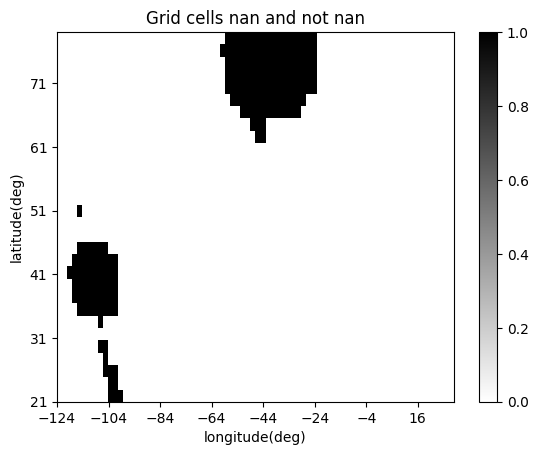

In [37]:
#Creo matrice
min_lon = models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lon.values.min()
max_lon = models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lon.values.max()
min_lat = models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lat.values.min()
max_lat = models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lat.values.max()
total_elements = n_rows * n_cols
matrix_to_plot = np.arange(total_elements).reshape((n_rows,n_cols))

#Sostituisco l'elemento nan con -999, usando cell_grid_nan
k = 0 #Inizializzo indice per cell_grid_nan
for i in range(n_rows):#ciclo sulle righe
    for j in range(n_cols): #ciclo sulle colonne
        if k < len(cell_grid_nan) and matrix_to_plot[i,j] == cell_grid_nan[k]:
            matrix_to_plot[i,j] = -999 #se l'elemento è nan allora lo inizializzo con -999
            k = k + 1 #ciclo su cell_grid_nan   
#Plot
matrix_to_plot[matrix_to_plot != -999] = 0 #Gli elementi diversi da -999 (nan) sono plottati in bianco
matrix_to_plot[matrix_to_plot == -999] = 1 # nero --> elementi nan
plt.imshow(matrix_to_plot[::-1], aspect='auto',cmap='binary',extent=[min_lon, max_lon, min_lat, max_lat],vmin=0,vmax=1)  # 'binary' cmap per bianco e nero
plt.xticks(np.arange(min_lon,max_lon, 20))
plt.yticks(np.arange(min_lat,max_lat, 10))
plt.colorbar()
plt.title('Grid cells nan and not nan')
plt.xlabel('longitude(deg)')
plt.ylabel('latitude(deg)')
plt.show()

Silhouette coefficient

In [38]:
X = feature_matrix
X.shape

(35, 2153)

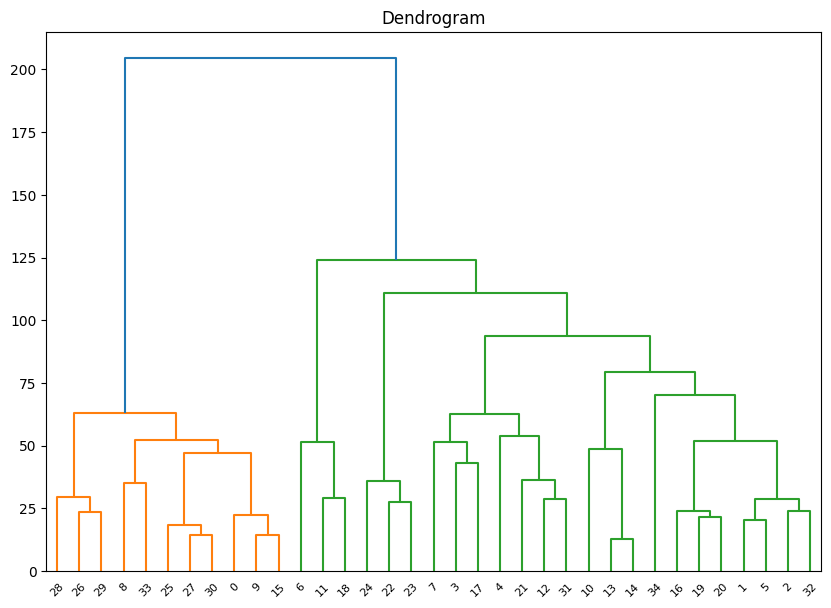

Etichette dei cluster: [28 30 25 33 19 20 27 26  9 32 29 21 23 34 24 13 12 31 22 14 18 17 11 10
  8 15  6 16  4  5  7  3  2  1  0]


In [39]:
#Hierarchical clustering agglomerative
# Definire il modello di clustering gerarchico
cluster_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(X) #The linkage distance threshold at or above which clusters will not be merged. = 0 ha senso solo se si desidera ottenere un dendrogramma completo, senza effettuare alcuna fusione automatica dei cluster

# Visualizzare il dendrogramma
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.show()

# Ottenere le etichette dei cluster
cluster_labels = cluster_model.labels_

# Stampare le etichette dei cluster
print("Etichette dei cluster:", cluster_labels)

#asse y distanza tra i cluster, asse x il numero dei cluster


Numero di componenti principali: 35
Varianza spiegata cumulativa: [0.47383171 0.62724911 0.73397144 0.79547876 0.84155833 0.86713416
 0.88735268 0.90449307 0.91683701 0.92797348 0.93852365 0.94713156
 0.95474996 0.9608281  0.96658349 0.97119038 0.97547022 0.97967497
 0.98270525 0.98552806 0.98789758 0.99014229 0.99203278 0.9936948
 0.99484754 0.99594473 0.99691966 0.9976502  0.99820191 0.99871177
 0.99911636 0.99946622 0.9997429  1.         1.        ]


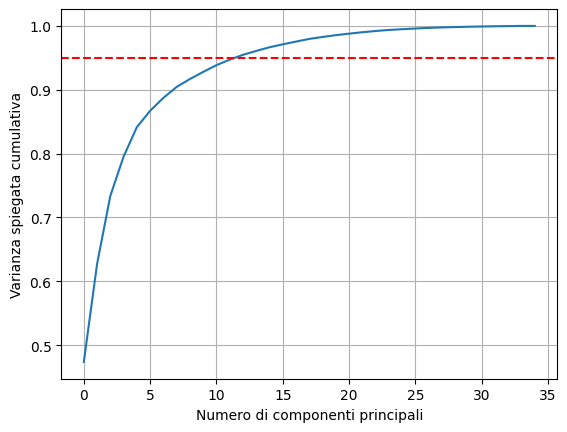

In [40]:
# Applica la PCA
pca = PCA() # se non indico il numero di componenti prende il minimo tra il numero di samples (41) e il numero di features (491)
X_pca = pca.fit_transform(X)

# Numero di componenti principali
num_components = pca.n_components_
print("Numero di componenti principali:", num_components)

# Varianza spiegata cumulativa
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)
print("Varianza spiegata cumulativa:", explained_variance_ratio_cumulative)

plt.plot(explained_variance_ratio_cumulative)
plt.axhline(y=0.95, color='r', linestyle='--') #retta al 95%
plt.xlabel('Numero di componenti principali')
plt.ylabel('Varianza spiegata cumulativa')
plt.grid(True)
plt.show()

In [41]:
pca = PCA(n_components=12)  # n_components = 10 per 95%, n_components = 22 per 99%
X_pca = pca.fit_transform(X)
X_pca.shape

(35, 12)

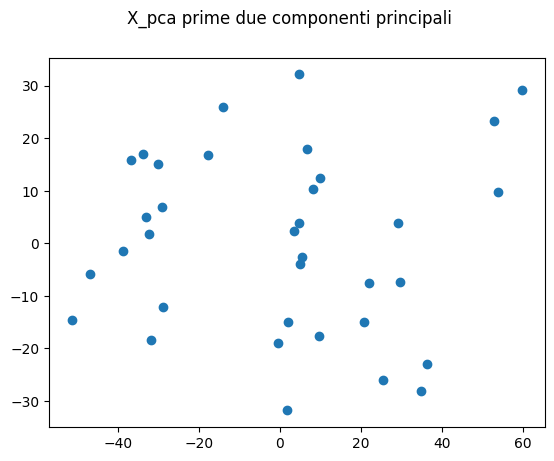

In [42]:
#plotto sulle prime due componenti principali X_pca
pca = PCA(n_components=2)  # n_components = 10 per 95%, n_components = 22 per 99%
X_pca2_plot = pca.fit_transform(X) #41x2
pl.scatter(X_pca2_plot[:, 0], X_pca2_plot[:, 1]) #plotto prima tutte le righe della prima colonna di X_pca_plot e poi tutte le righe della seconda colonna
plt.suptitle('X_pca prime due componenti principali')
plt.show()

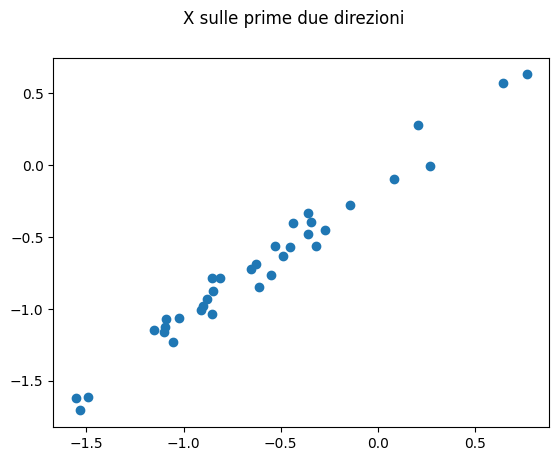

In [43]:
#plot X sulle prime due direzioni
pl.scatter(X[:,0], X[:,1])
plt.suptitle('X sulle prime due direzioni')
plt.show()

Clusterizzazione

clusterization 2 iteration number 0 max_sil_avg =  0.25203582368636224
clusterization 2 iteration number 0 max_sil_avg =  0.25203582368636224
clusterization 3 iteration number 0 max_sil_avg =  0.2726778071974314
clusterization 3 iteration number 0 max_sil_avg =  0.2726778071974314
clusterization 4 iteration number 0 max_sil_avg =  0.22521231325056282
clusterization 4 iteration number 0 max_sil_avg =  0.22521231325056282
clusterization 5 iteration number 0 max_sil_avg =  0.23346754388405883
clusterization 5 iteration number 0 max_sil_avg =  0.23346754388405883
clusterization 6 iteration number 0 max_sil_avg =  0.23777812151527042
clusterization 6 iteration number 0 max_sil_avg =  0.23777812151527042


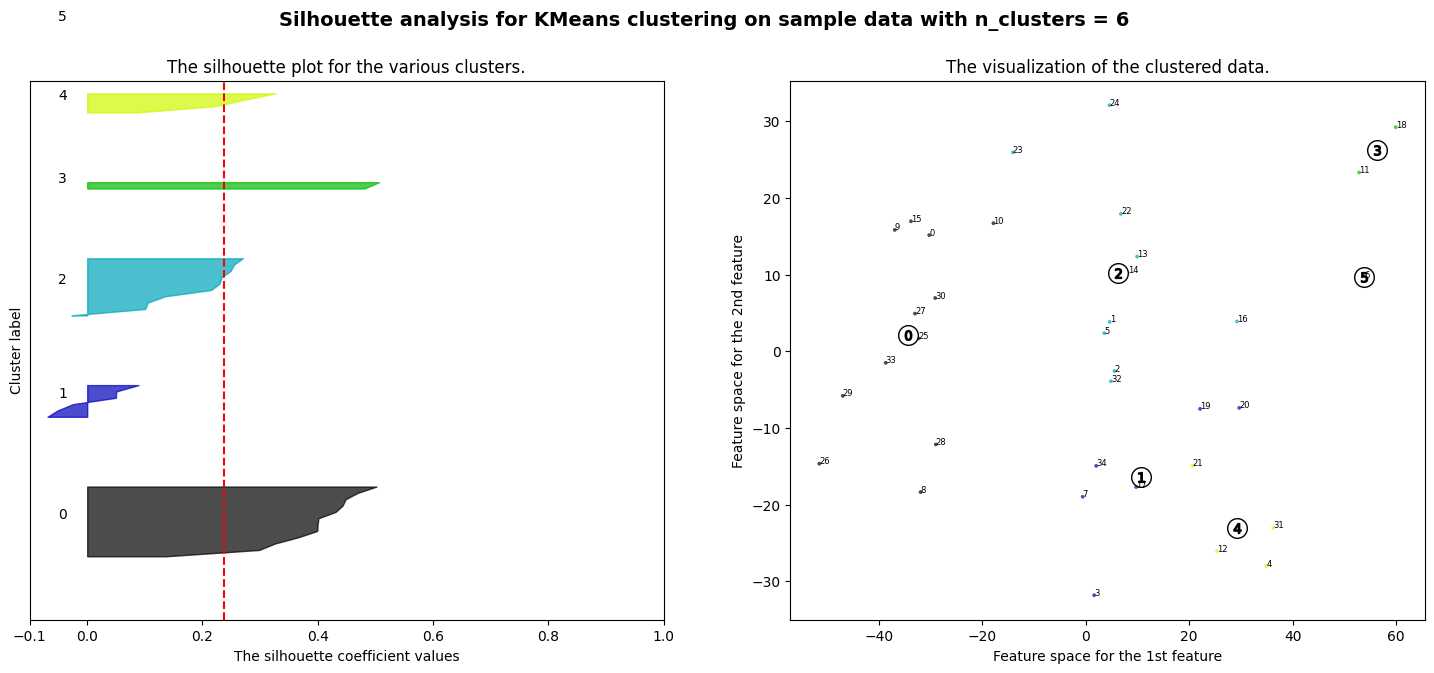

clusterization 7 iteration number 0 max_sil_avg =  0.23453000599224977
clusterization 7 iteration number 0 max_sil_avg =  0.23453000599224977
clusterization 8 iteration number 0 max_sil_avg =  0.21678069227870247
clusterization 8 iteration number 0 max_sil_avg =  0.21678069227870247
clusterization 2 iteration number 1 max_sil_avg =  0.31313698683278884
clusterization 3 iteration number 1 max_sil_avg =  0.2997897134073688
clusterization 4 iteration number 1 max_sil_avg =  0.2630675819408597
clusterization 5 iteration number 1 max_sil_avg =  0.2989488322618143
clusterization 6 iteration number 1 max_sil_avg =  0.24041444354741098


<Figure size 640x480 with 0 Axes>

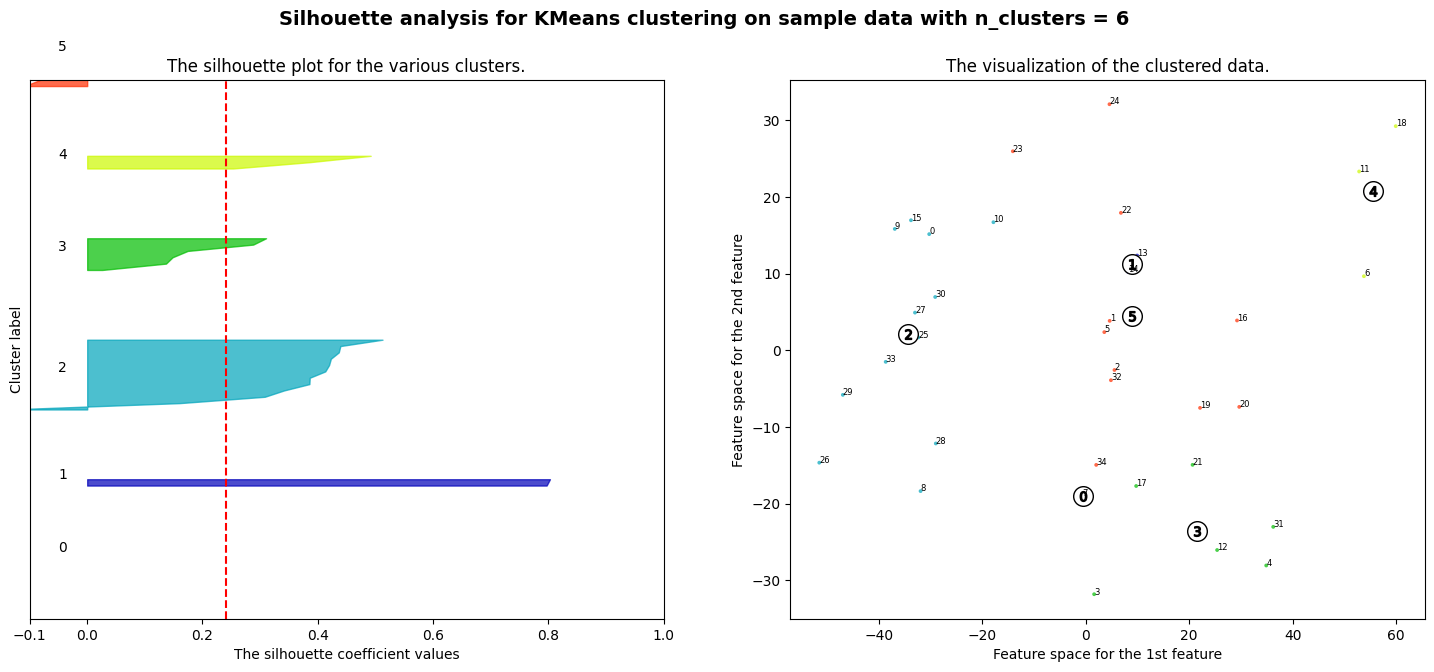

clusterization 7 iteration number 1 max_sil_avg =  0.2358094809274414
clusterization 8 iteration number 1 max_sil_avg =  0.2440274886313702
clusterization 8 iteration number 2 max_sil_avg =  0.24988954498348456
clusterization 2 iteration number 3 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 3 max_sil_avg =  0.3266772703749477
clusterization 8 iteration number 3 max_sil_avg =  0.27989605937152434
clusterization 2 iteration number 4 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 5 max_sil_avg =  0.31313698683278884
clusterization 6 iteration number 5 max_sil_avg =  0.28551928966820483


<Figure size 640x480 with 0 Axes>

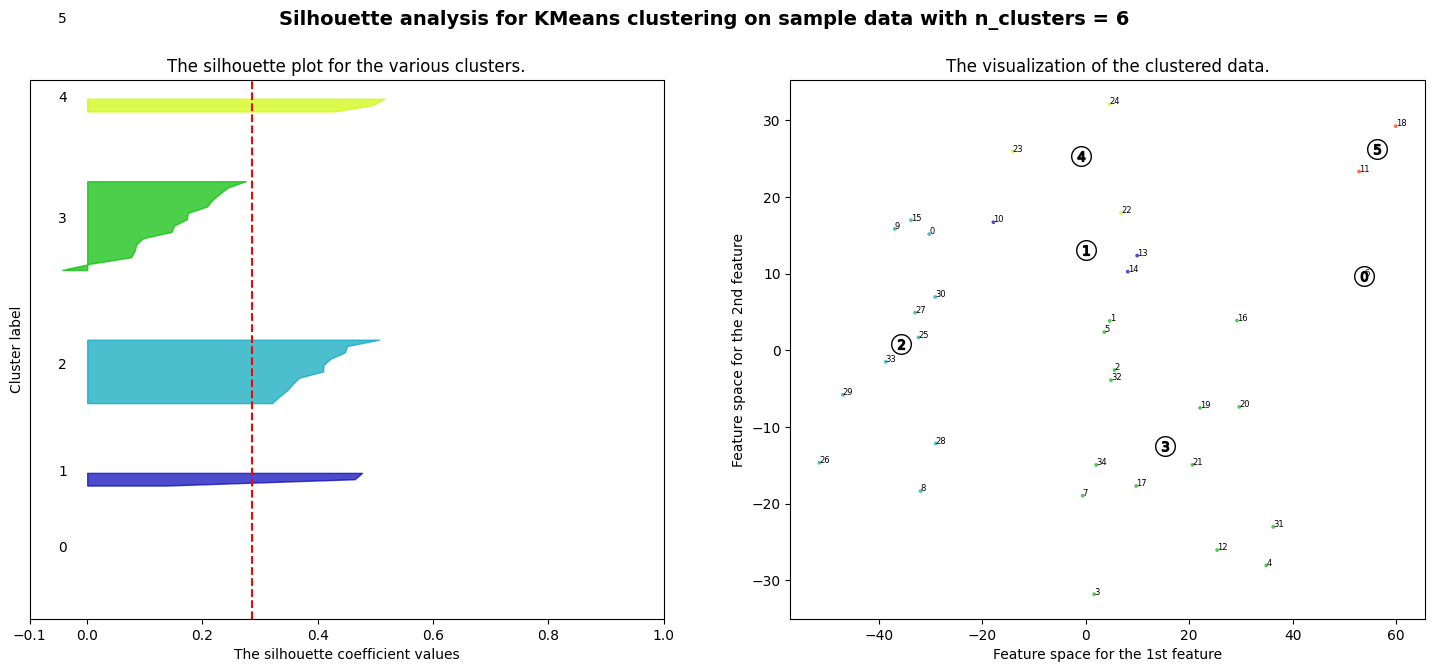

clusterization 7 iteration number 5 max_sil_avg =  0.23825585824346576
clusterization 2 iteration number 6 max_sil_avg =  0.31313698683278884
clusterization 7 iteration number 7 max_sil_avg =  0.30087005580030335
clusterization 2 iteration number 8 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 9 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 9 max_sil_avg =  0.3266772703749477
clusterization 5 iteration number 10 max_sil_avg =  0.31999034103280577
clusterization 2 iteration number 11 max_sil_avg =  0.31313698683278884
clusterization 6 iteration number 11 max_sil_avg =  0.29503168786026157


<Figure size 640x480 with 0 Axes>

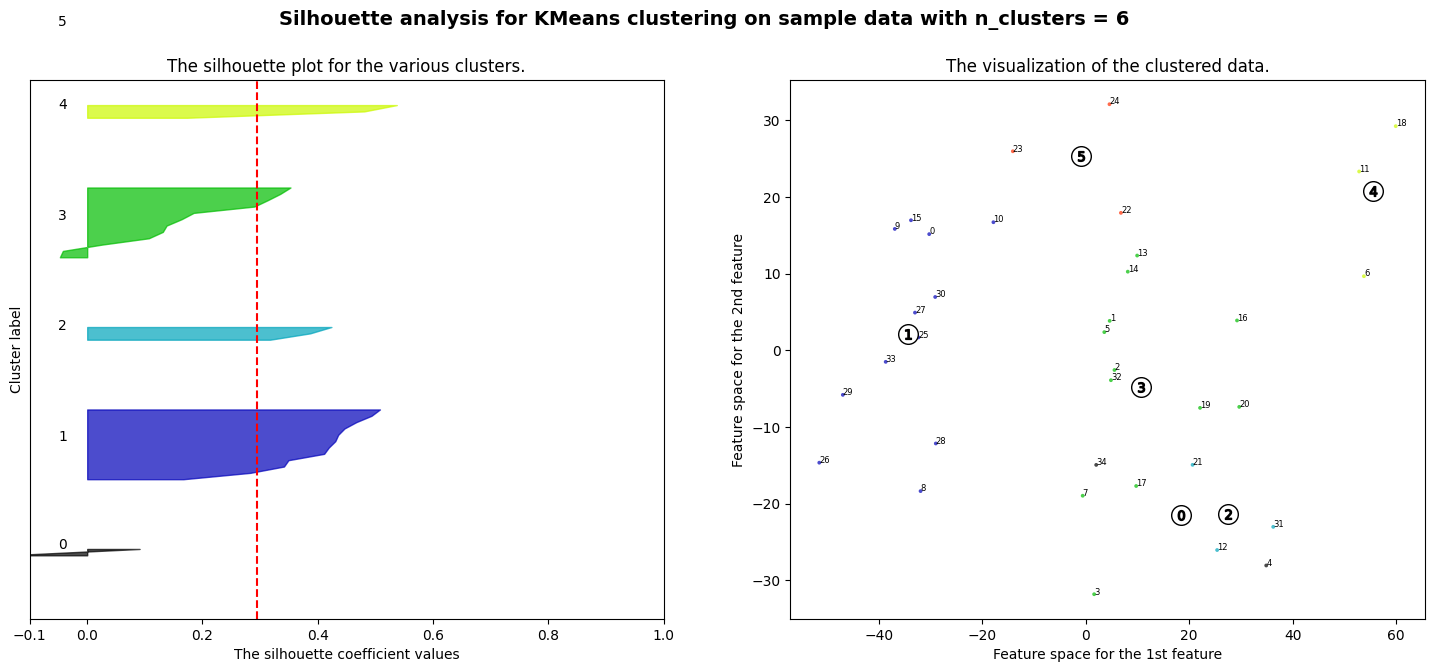

clusterization 2 iteration number 12 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 13 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 14 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 15 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 16 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 16 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 17 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 18 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 18 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 19 max_sil_avg =  0.31313698683278884
clusterization 6 iteration number 19 max_sil_avg =  0.29503168786026157


<Figure size 640x480 with 0 Axes>

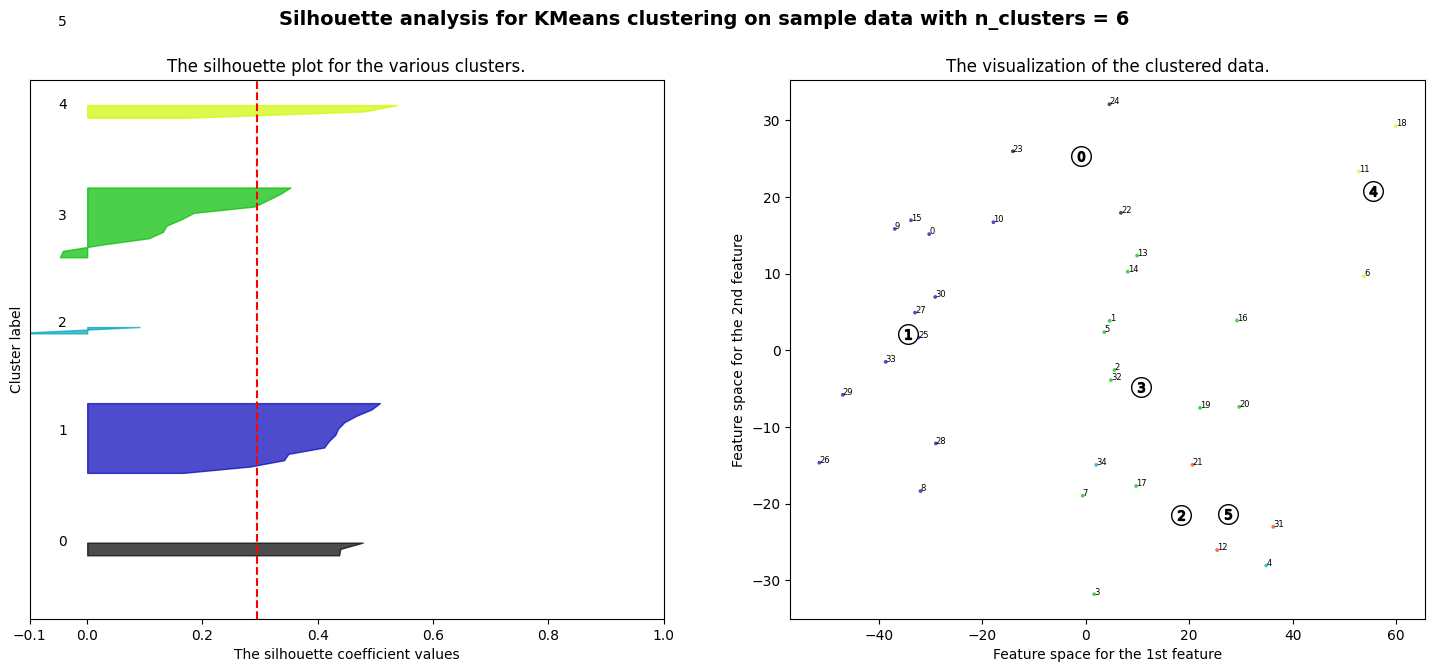

clusterization 2 iteration number 20 max_sil_avg =  0.31313698683278884
clusterization 5 iteration number 20 max_sil_avg =  0.31999034103280577
clusterization 6 iteration number 20 max_sil_avg =  0.29775732809830174


<Figure size 640x480 with 0 Axes>

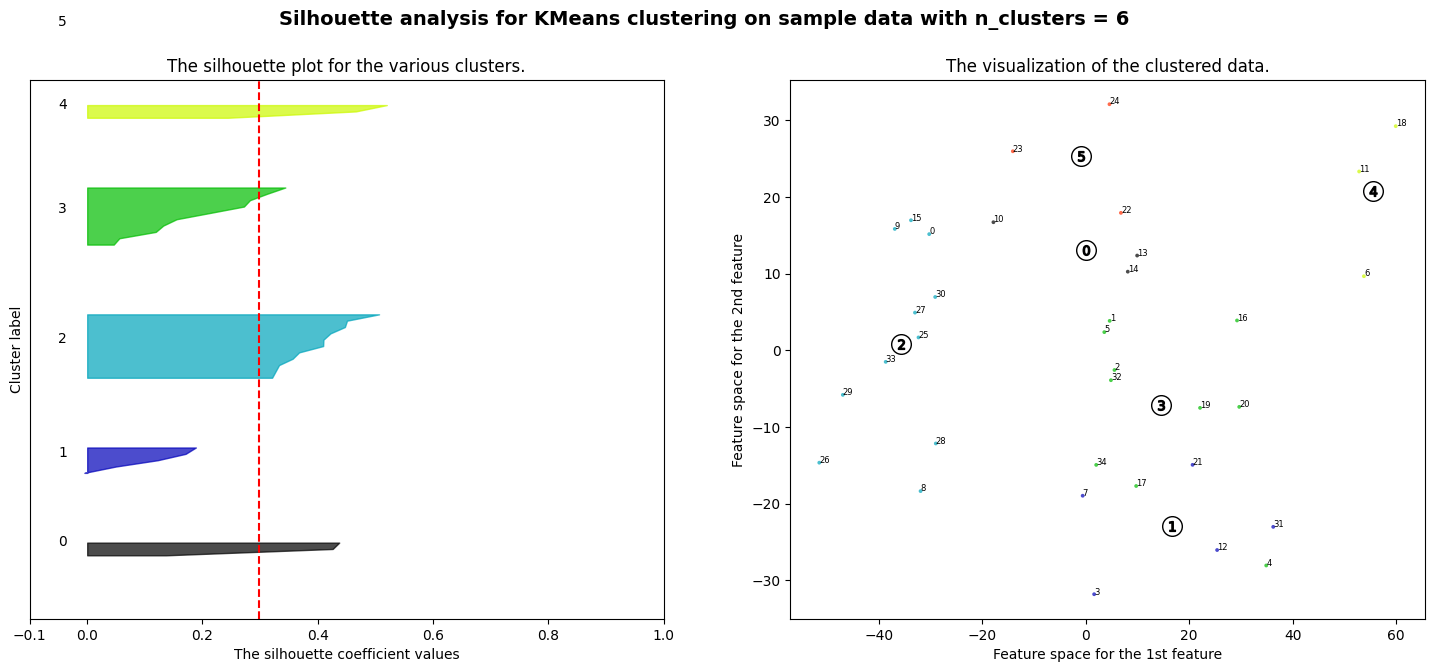

clusterization 2 iteration number 21 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 23 max_sil_avg =  0.31313698683278884
clusterization 3 iteration number 23 max_sil_avg =  0.2997897134073688
clusterization 8 iteration number 23 max_sil_avg =  0.28690263127930016
clusterization 2 iteration number 26 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 27 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 29 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 29 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 30 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 30 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 31 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 32 max_sil_avg =  0.31313698683278884
clusterization 3 iteration number 32 max_sil_avg =  0.2997897134073688
clusterization 2 iteration number 33 max_sil_avg =  0.31313698683278

<Figure size 640x480 with 0 Axes>

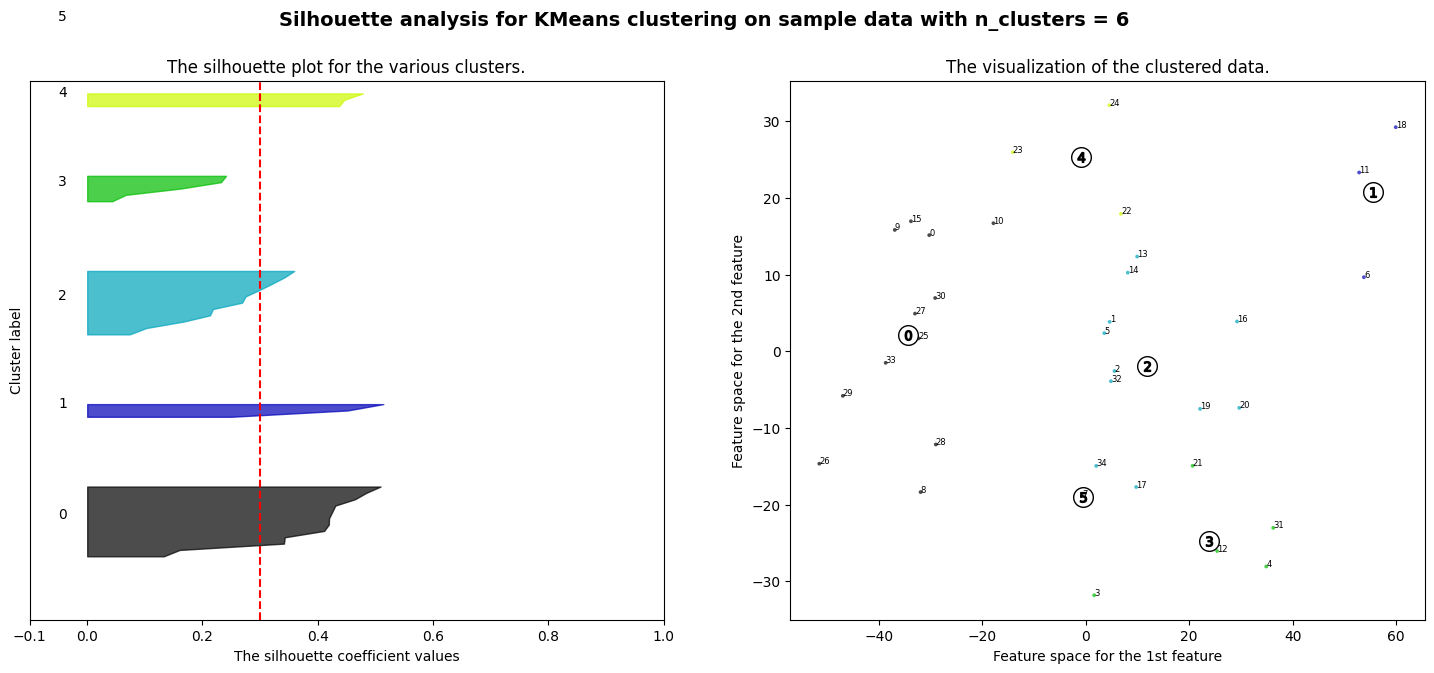

clusterization 3 iteration number 41 max_sil_avg =  0.2997897134073688
clusterization 2 iteration number 43 max_sil_avg =  0.31313698683278884
clusterization 3 iteration number 43 max_sil_avg =  0.2997897134073688
clusterization 2 iteration number 44 max_sil_avg =  0.31313698683278884
clusterization 8 iteration number 44 max_sil_avg =  0.29985661697652194
clusterization 2 iteration number 45 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 47 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 48 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 50 max_sil_avg =  0.31313698683278884
clusterization 3 iteration number 50 max_sil_avg =  0.2997897134073688
clusterization 2 iteration number 51 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 52 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 53 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 53 max_sil_avg =  0.326677270374947

<Figure size 640x480 with 0 Axes>

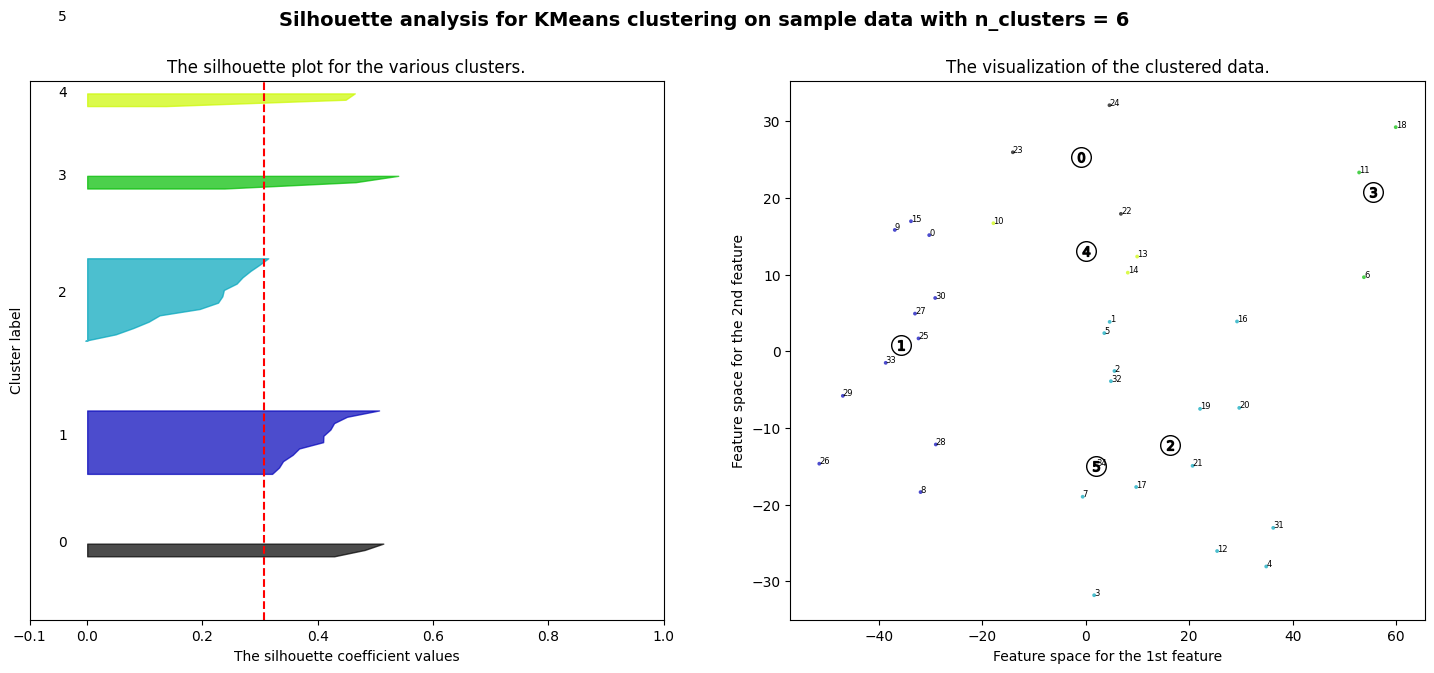

clusterization 4 iteration number 59 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 60 max_sil_avg =  0.31313698683278884
clusterization 3 iteration number 60 max_sil_avg =  0.2997897134073688
clusterization 4 iteration number 60 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 62 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 63 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 64 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 65 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 66 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 68 max_sil_avg =  0.31313698683278884
clusterization 2 iteration number 69 max_sil_avg =  0.31313698683278884
clusterization 4 iteration number 69 max_sil_avg =  0.3266772703749477
clusterization 4 iteration number 70 max_sil_avg =  0.3266772703749477
clusterization 2 iteration number 72 max_sil_avg =  0.313136986832788

<Figure size 640x480 with 0 Axes>

In [44]:
#100 iterazioni, con X_pca

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
#X = feature_matrix
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
#clusterization = 5 #elemento di range_n_clusters scelto per scegliere in quanti cluster suddividere il dataset
 #Indici per il conteggio di quante volte è comparso un valore negativo, dopo 100 iterazioni
i = 0 #2 cluster
j = 0 #3 cluster
k = 0 #4 cluster
l = 0 #5 cluster
m = 0 #6 cluster
n = 0 #7 cluster
#Valori per il calcolo della media di silhouette_avg
a = 0
b = 0
c = 0
d = 0
e = 0
f = 0
g = 0
#Inizializzo il vettore in cui andrò a mettere tutti i silhouette_avg
iterations = 100
sil_avg_pca = np.zeros((len(range_n_clusters),iterations)) #dimensioni pari al numero di iterazioni, per ogni clusterizzazione
labels_pca = np.zeros((len(range_n_clusters),len(X_pca))) #41 pari al numero di modelli
centroids_pca = np.zeros((len(range_n_clusters),len(X_pca.T))) #7x4x10
max_sil_avg_pca = - np.ones(len(range_n_clusters)) #inizializzazione per il massimo
#Inizializzo un vettore che ha indice pari al valore delle righe, in modo tale da individuare ogni modello all'interno del plot
index_models_pca = np.arange(len(X_pca))# [0,1,2,...,40]

#100 iterazioni
for p in range(iterations):
    
    for n_clusters in range_n_clusters:

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters,init='k-means++') # k-means++ per inizializzare i centroid + distanti iin modo da evitare i minimi locali
        cluster_labels = clusterer.fit_predict(X_pca)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X_pca, cluster_labels) #il valore medio del silhouette score tra tutti i cluster
        #aggiorno i valori per poi calcolare la media di silhouette_avg
        if n_clusters == range_n_clusters[0]: #2 cluster
            a = a + silhouette_avg
            sil2 = silhouette_avg  
            sil_avg_pca[0][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[0] = sil_avg_pca[0][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[0])         
            if sil_avg_pca[0][p] >= max_sil_avg_pca[0]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[0] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[0] = sil_avg_pca[0][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[0])

            
        elif n_clusters == range_n_clusters[1]: #3 cluster
            b = b + silhouette_avg
            sil3 = silhouette_avg  
            sil_avg_pca[1][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[1] = sil_avg_pca[1][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[1])         
            if sil_avg_pca[1][p] >= max_sil_avg_pca[1]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[1] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[1] = sil_avg_pca[1][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[1])

        elif n_clusters == range_n_clusters[2]: #4 cluster
            c = c + silhouette_avg            
            sil4 = silhouette_avg  
            sil_avg_pca[2][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[2] = sil_avg_pca[2][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[2])         
            if sil_avg_pca[2][p] >= max_sil_avg_pca[2]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[2] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[2] = sil_avg_pca[2][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[2])

        elif n_clusters == range_n_clusters[3]: #5 cluster
            d = d + silhouette_avg
            sil5 = silhouette_avg#Prendo il silhouette_avg maggiore (lo faccio solo per 4 cluster) e fisso i labels e i centers  
            sil_avg_pca[3][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[3] = sil_avg_pca[3][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[3])         
            if sil_avg_pca[3][p] >= max_sil_avg_pca[3]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[3] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[3] = sil_avg_pca[3][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[3])

            
        elif n_clusters == range_n_clusters[4]: #6 cluster
            e = e + silhouette_avg  
            sil6 = silhouette_avg#Inserisco silhouette_avg in un vettore  
            sil_avg_pca[4][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[4] = sil_avg_pca[4][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[4])         
            if sil_avg_pca[4][p] >= max_sil_avg_pca[4]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[4] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[4] = sil_avg_pca[4][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[4])
                #plot del silhouette coefficient
                #assi per il plot
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.set_size_inches(18,7)

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X_pca) + (4 + 1) * 10]) #dove 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X_pca) + (4 + 1) * 10]) # len(X) = numero di modelli e quindi il numero di samples. 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
                
                y_lower = 10
                for i in range(n_clusters):
                    # Aggregate the silhouette scores for samples belonging to
                    # cluster i, and sort them
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax1.fill_betweenx(
                        np.arange(y_lower, y_upper),
                        0,
                        ith_cluster_silhouette_values,
                        facecolor=color,
                        edgecolor=color,
                        alpha=0.7,
                    )

                    # Label the silhouette plots with their cluster numbers at the middle
                    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    # Compute the new y_lower for next plot
                    y_lower = y_upper + 10  # 10 for the 0 samples

                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")

                # The vertical line for average silhouette score of all the values
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax1.set_yticks([])  # Clear the yaxis labels / ticks
                ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                # 2nd Plot showing the actual clusters formed
                colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
                ax2.scatter(
                    X_pca[:, 0], X_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
                )
                # Annotazione dei numeri degli indici
                for i, txt in enumerate(index_models_pca):
                    ax2.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=6)

                # Draw white circles at cluster centers
                ax2.scatter(
                    centroids_pca[:, 0],
                    centroids_pca[:, 1],
                    marker="o",
                    c="white",
                    alpha=1,
                    s=200,
                    edgecolor="k",
                )

                for i, c in enumerate(centroids_pca):
                    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

                ax2.set_title("The visualization of the clustered data.")
                ax2.set_xlabel("Feature space for the 1st feature")
                ax2.set_ylabel("Feature space for the 2nd feature")

                plt.suptitle(
                    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                    % n_clusters,
                    fontsize=14,
                    fontweight="bold",
                )

                plt.show()
                plt.savefig('sil_coeff_X_pca.pdf', format='pdf')
                fig.clf() #elimino il grafico pre-esistente 
            
        elif n_clusters == range_n_clusters[5]: #7 cluster
            f = f + silhouette_avg
            sil7 = silhouette_avg   
            sil_avg_pca[5][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[5] = sil_avg_pca[5][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[5])         
            if sil_avg_pca[5][p] >= max_sil_avg_pca[5]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[5] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[5] = sil_avg_pca[5][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[5])     
                 
        elif n_clusters == range_n_clusters[6]: #8 cluster
            g = g + silhouette_avg
            sil8 = silhouette_avg  
            sil_avg_pca[6][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg_pca[6] = sil_avg_pca[6][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[6])         
            if sil_avg_pca[6][p] >= max_sil_avg_pca[6]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels_pca[6] = clusterer.labels_ #labels
                centroids_pca = clusterer.cluster_centers_ #centroids 
                max_sil_avg_pca[6] = sil_avg_pca[6][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg_pca[6])


        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X_pca, cluster_labels)
    
        if np.any(sample_silhouette_values < 0):
            #print("For n_clusters =", n_clusters, "there are negative silhouette values.") #Se almeno uno dei samples ha sil coeff < 0
            #Aggiorno il conteggio quando ho un valore dei coefficienti negativo per ogni iterazione
            if n_clusters == range_n_clusters[0]:
                i = i + 1
            elif n_clusters == range_n_clusters[1]:
                j = j + 1
            elif n_clusters == range_n_clusters[2]:
                k = k + 1
            elif n_clusters == range_n_clusters[3]:
                l = l + 1
            elif n_clusters == range_n_clusters[4]:
                m = m + 1  
            elif n_clusters == range_n_clusters[5]:
                n = n + 1

cluster_2_mean = a / iterations
cluster_3_mean = b / iterations
cluster_4_mean = c / iterations
cluster_5_mean = d / iterations
cluster_6_mean = e / iterations
cluster_7_mean = f / iterations

#print("n_clusters = ", range_n_clusters[0], "has", i, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_2_mean)
#print("n_clusters = ", range_n_clusters[1], "has", j, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_3_mean)
#print("n_clusters = ", range_n_clusters[2], "has", k, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_4_mean)
#print("n_clusters = ", range_n_clusters[3], "has", l, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_5_mean)
#print("n_clusters = ", range_n_clusters[4], "has", m, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_6_mean)
#print("n_clusters = ", range_n_clusters[5], "has", n, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_7_mean)


In [45]:
max_sil_avg_pca

array([0.31313699, 0.29978971, 0.32667727, 0.31999034, 0.30676039,
       0.30147117, 0.30388914])

clusterization 2 iteration number 0 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 0 max_sil_avg =  0.29156770784383895
clusterization 3 iteration number 0 max_sil_avg =  0.24102264316334068
clusterization 3 iteration number 0 max_sil_avg =  0.24102264316334068
clusterization 4 iteration number 0 max_sil_avg =  0.24102264316334068
clusterization 4 iteration number 0 max_sil_avg =  0.1829902608522747
clusterization 5 iteration number 0 max_sil_avg =  0.15157309431164392
clusterization 5 iteration number 0 max_sil_avg =  0.15157309431164392
clusterization 6 iteration number 0 max_sil_avg =  0.15021697135598217
clusterization 6 iteration number 0 max_sil_avg =  0.15021697135598217


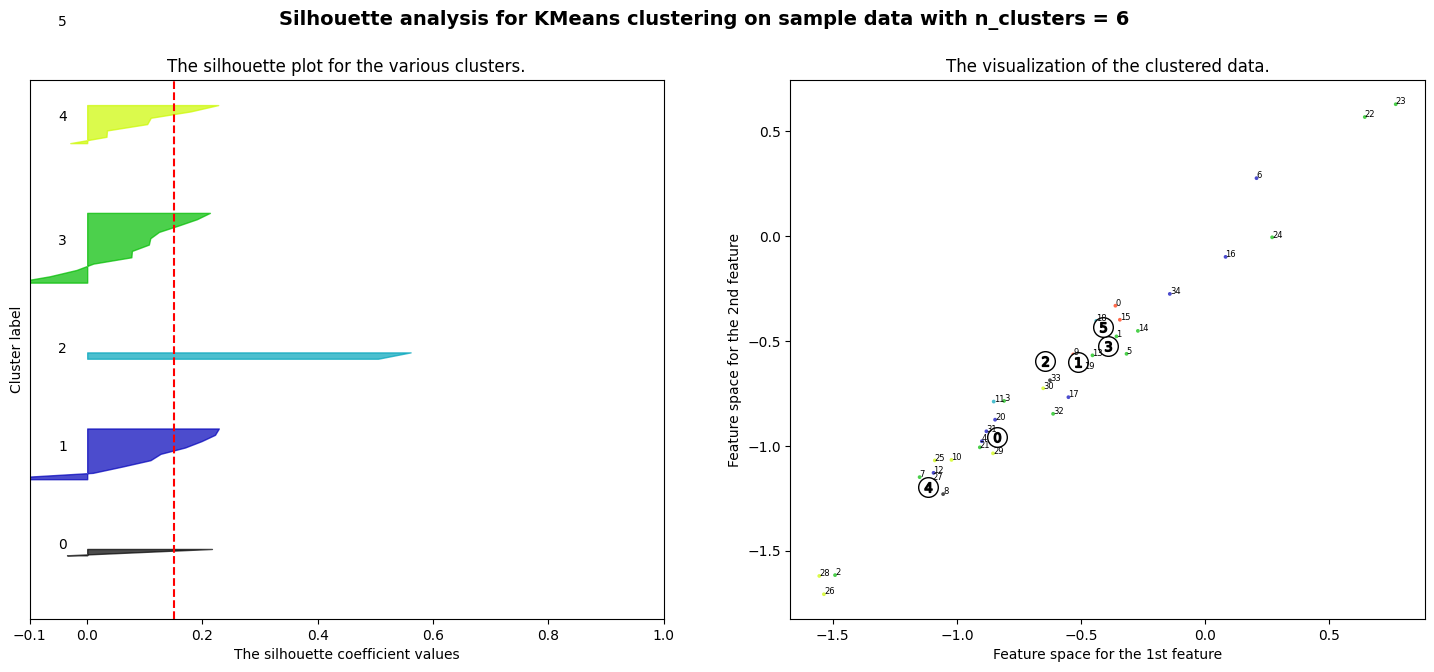

clusterization 7 iteration number 0 max_sil_avg =  0.21975211319207877
clusterization 7 iteration number 0 max_sil_avg =  0.21975211319207877
clusterization 8 iteration number 0 max_sil_avg =  0.20234685251846016
clusterization 8 iteration number 0 max_sil_avg =  0.20234685251846016
clusterization 6 iteration number 1 max_sil_avg =  0.19935219552830205


<Figure size 640x480 with 0 Axes>

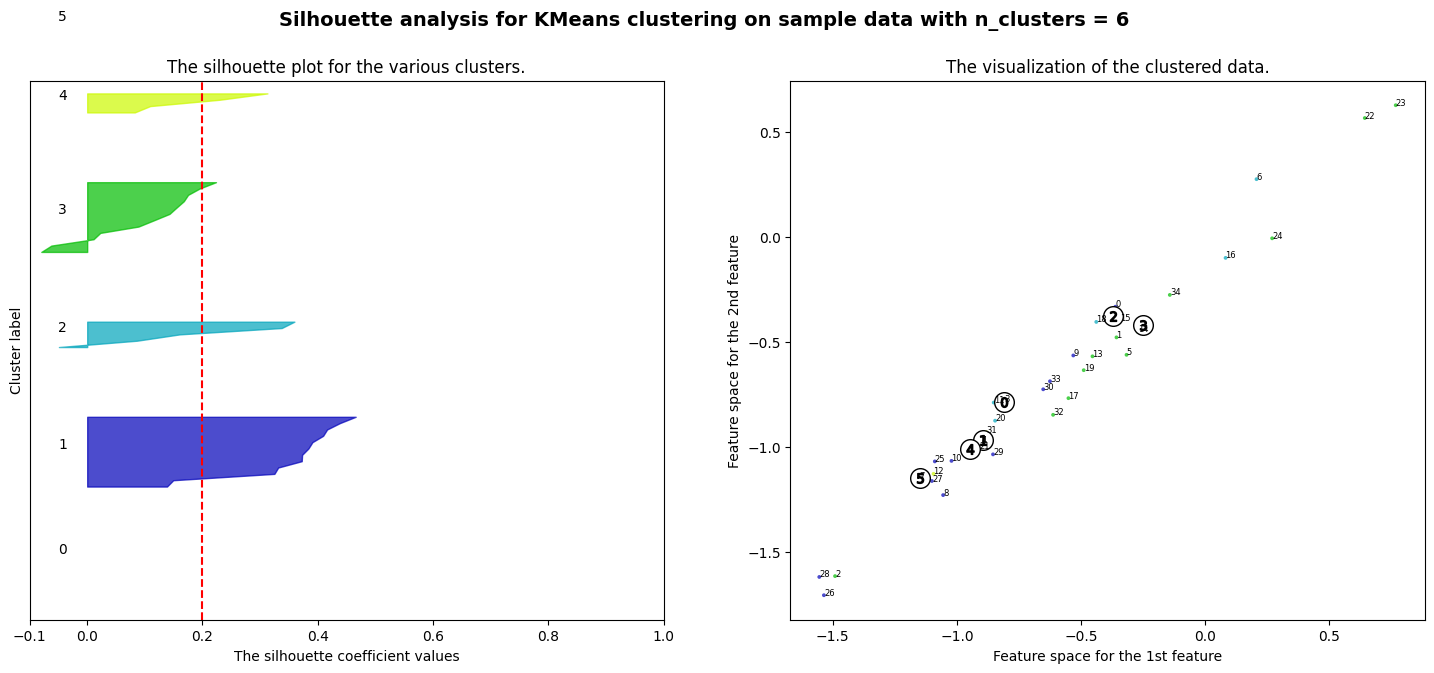

clusterization 3 iteration number 2 max_sil_avg =  0.2695965100281314
clusterization 4 iteration number 2 max_sil_avg =  0.18509594450777972
clusterization 6 iteration number 2 max_sil_avg =  0.19984761723880476


<Figure size 640x480 with 0 Axes>

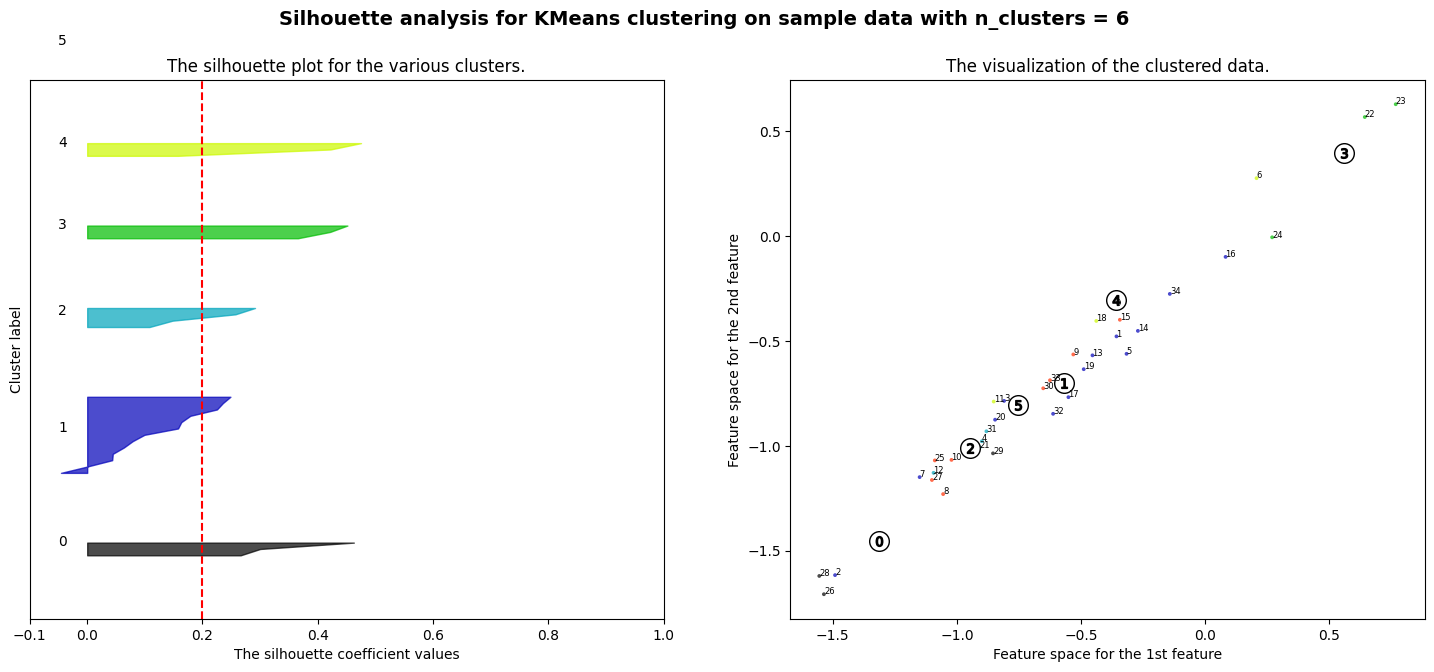

clusterization 7 iteration number 2 max_sil_avg =  0.24044407359695552
clusterization 8 iteration number 2 max_sil_avg =  0.21002650128921418
clusterization 2 iteration number 3 max_sil_avg =  0.29156770784383895
clusterization 4 iteration number 3 max_sil_avg =  0.2222168046487809
clusterization 5 iteration number 3 max_sil_avg =  0.1602833646750391
clusterization 3 iteration number 4 max_sil_avg =  0.27253459537093383
clusterization 4 iteration number 4 max_sil_avg =  0.24555172049167331
clusterization 4 iteration number 5 max_sil_avg =  0.2881974919512143
clusterization 5 iteration number 5 max_sil_avg =  0.22584311649108027
clusterization 6 iteration number 5 max_sil_avg =  0.20216761693719132


<Figure size 640x480 with 0 Axes>

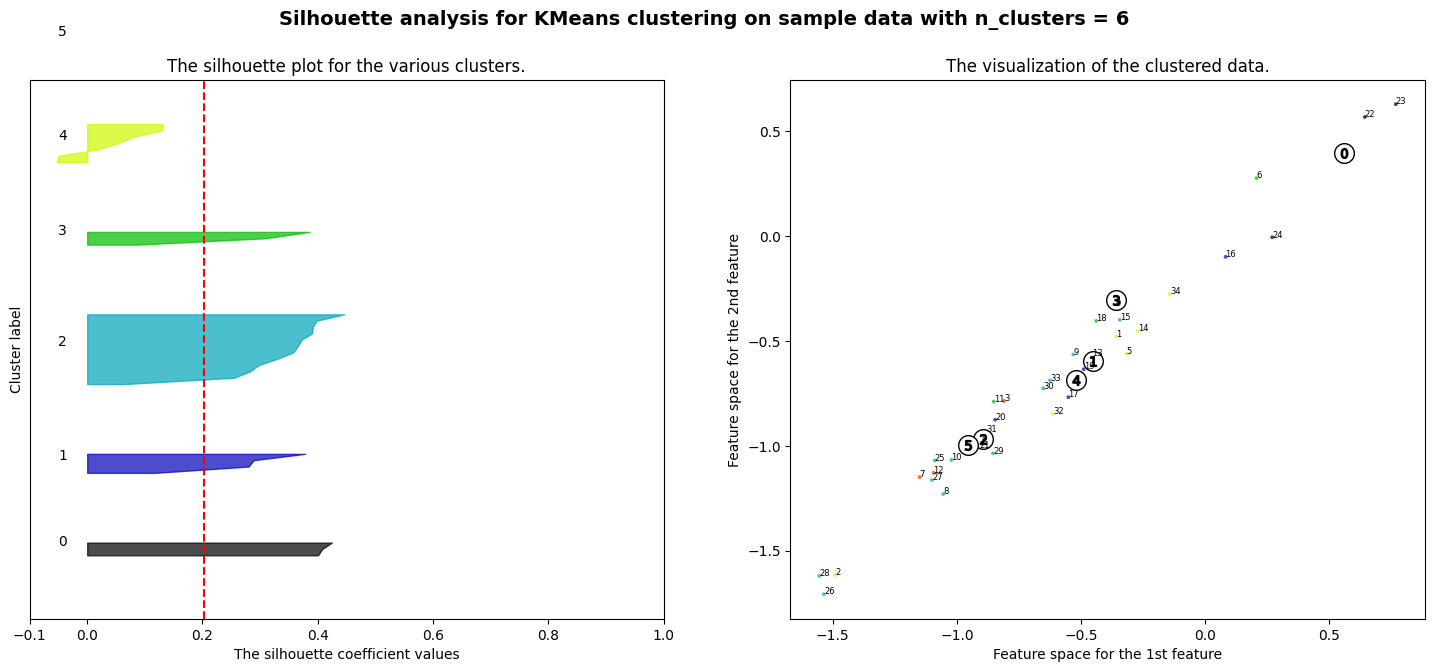

clusterization 2 iteration number 6 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 7 max_sil_avg =  0.29156770784383895
clusterization 5 iteration number 7 max_sil_avg =  0.2405795969093529
clusterization 8 iteration number 7 max_sil_avg =  0.23400982624014885
clusterization 2 iteration number 9 max_sil_avg =  0.29156770784383895
clusterization 5 iteration number 9 max_sil_avg =  0.2608016515478246
clusterization 6 iteration number 9 max_sil_avg =  0.27226595436730755


<Figure size 640x480 with 0 Axes>

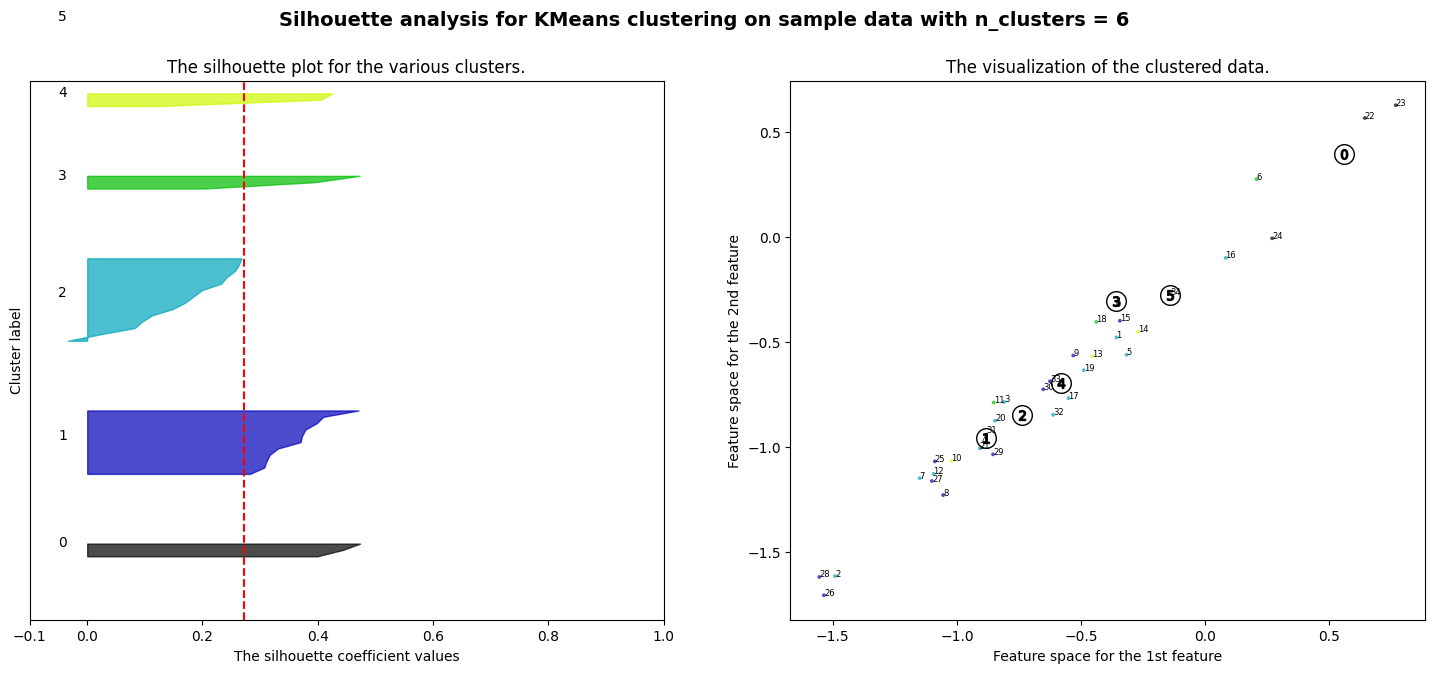

clusterization 2 iteration number 10 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 11 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 13 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 14 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 15 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 17 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 18 max_sil_avg =  0.29156770784383895
clusterization 8 iteration number 18 max_sil_avg =  0.24428082278520818
clusterization 2 iteration number 19 max_sil_avg =  0.29156770784383895
clusterization 4 iteration number 19 max_sil_avg =  0.2956712855674521
clusterization 7 iteration number 19 max_sil_avg =  0.24436423962420437
clusterization 2 iteration number 20 max_sil_avg =  0.29156770784383895
clusterization 3 iteration number 20 max_sil_avg =  0.27253459537093383
clusterization 2 iteration number 21 max_sil_avg =  0.29156770784

<Figure size 640x480 with 0 Axes>

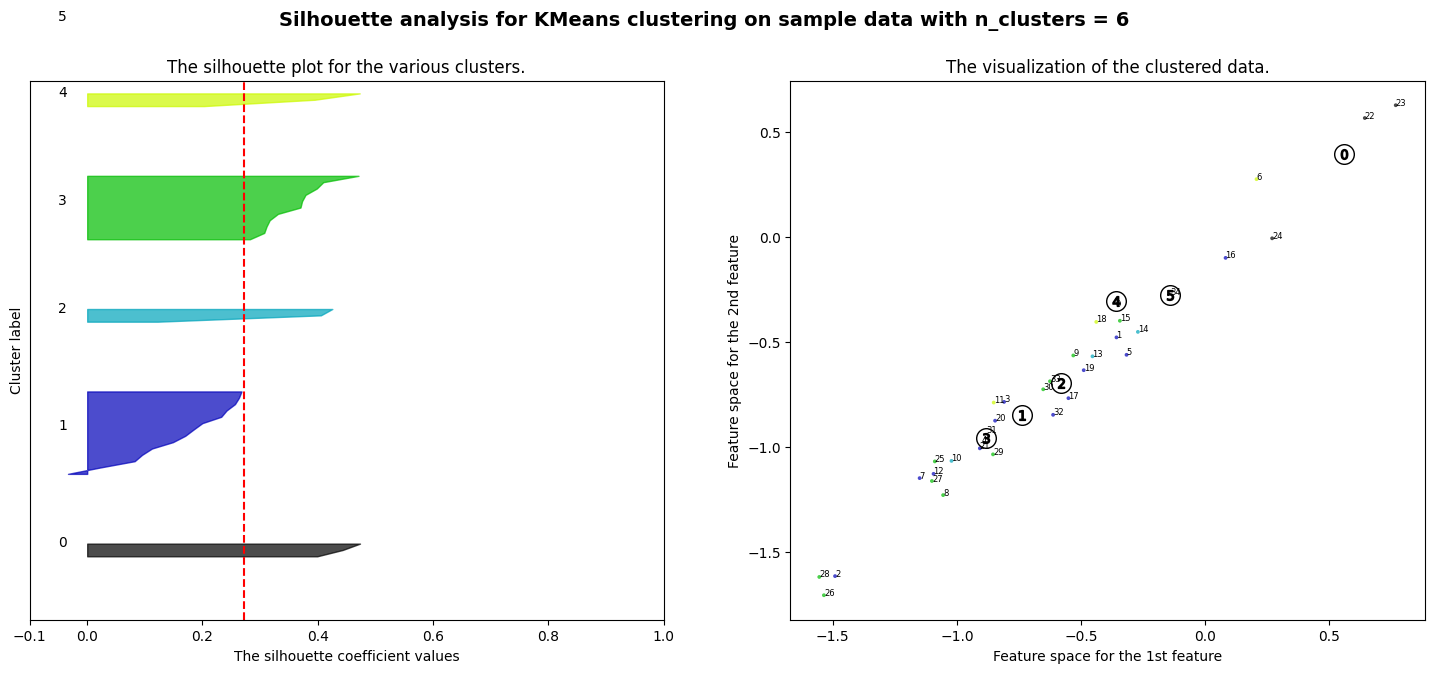

clusterization 2 iteration number 81 max_sil_avg =  0.29156770784383895
clusterization 7 iteration number 81 max_sil_avg =  0.2631670332657566
clusterization 3 iteration number 82 max_sil_avg =  0.27253459537093383
clusterization 2 iteration number 83 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 84 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 86 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 87 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 88 max_sil_avg =  0.29156770784383895
clusterization 3 iteration number 89 max_sil_avg =  0.27253459537093383
clusterization 2 iteration number 90 max_sil_avg =  0.29156770784383895
clusterization 4 iteration number 90 max_sil_avg =  0.2956712855674521
clusterization 2 iteration number 91 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 93 max_sil_avg =  0.29156770784383895
clusterization 2 iteration number 94 max_sil_avg =  0.291567707843

<Figure size 640x480 with 0 Axes>

In [46]:
#100 iterazioni, con X

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
#X = feature_matrix
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

 #Indici per il conteggio di quante volte è comparso un valore negativo, dopo 100 iterazioni
i = 0 #2 cluster
j = 0 #3 cluster
k = 0 #4 cluster
l = 0 #5 cluster
m = 0 #6 cluster
n = 0 #7 cluster
#Valori per il calcolo della media di silhouette_avg
a = 0
b = 0
c = 0
d = 0
e = 0
f = 0
g = 0
#Inizializzo il vettore in cui andrò a mettere tutti i silhouette_avg
iterations = 100
sil_avg = np.zeros((len(range_n_clusters),iterations)) #dimensioni pari al numero di iterazioni
labels = np.zeros((len(range_n_clusters),len(X))) #41 pari al numero di modelli
centroids = np.zeros((len(range_n_clusters),len(X.T)))  #5x10
max_sil_avg = - np.ones(len(range_n_clusters))
#Inizializzo un vettore che ha indice pari al valore delle righe, in modo tale da individuare ogni modello all'interno del plot
index_models = np.arange(len(X)) # [0,1,2,...,40]

#100 iterazioni
for p in range(iterations):
    
    for n_clusters in range_n_clusters:

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters,init='k-means++') # k-means++ per inizializzare i centroid + distanti iin modo da evitare i minimi locali
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels) #il valore medio del silhouette score tra tutti i cluster
        #aggiorno i valori per poi calcolare la media di silhouette_avg
        if n_clusters == range_n_clusters[0]: #2 cluster
            a = a + silhouette_avg
            sil_avg[0][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[0] = sil_avg[0][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[0])         
            if sil_avg[0][p] >= max_sil_avg[0]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels[0] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[0] = sil_avg[0][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[0])
        elif n_clusters == range_n_clusters[1]: #3 cluster
            b = b + silhouette_avg
            sil_avg[1][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[1] = sil_avg[1][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[1])         
            if sil_avg[1][p] >= max_sil_avg[1]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels[1] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[1] = sil_avg[1][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[1])
        elif n_clusters == range_n_clusters[2]: #4 cluster
            c = c + silhouette_avg
            sil_avg[2][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[2] = sil_avg[2][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[1])         
            if sil_avg[2][p] >= max_sil_avg[2]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels[2] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[2] = sil_avg[2][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[2])
        elif n_clusters == range_n_clusters[3]: #5 cluster
            d = d + silhouette_avg
            sil_avg[3][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[3] = sil_avg[3][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[3])         
            if sil_avg[3][p] >= max_sil_avg[3]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels[3] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[3] = sil_avg[3][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[3])
            
        elif n_clusters == range_n_clusters[4]: #6 cluster
            e = e + silhouette_avg  
            sil_avg[4][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[4] = sil_avg[4][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[4])         
            if sil_avg[4][p] >= max_sil_avg[4]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels[4] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[4] = sil_avg[4][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[4])
                #plot del silhouette coefficient
                #assi per il plot
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.set_size_inches(18,7)

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X) + (4 + 1) * 10]) #dove 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # The 1st subplot is the silhouette plot
                # The silhouette coefficient can range from -1, 1 but in this example all
                # lie within [-0.1, 1]
                ax1.set_xlim([-0.1, 1])
                # The (n_clusters+1)*10 is for inserting blank space between silhouette
                # plots of individual clusters, to demarcate them clearly.
                ax1.set_ylim([0, len(X) + (4 + 1) * 10]) # len(X) = numero di modelli e quindi il numero di samples. 4 = n_clusters perché il plot lo faccio solo per 4 clusters

                # Compute the silhouette scores for each sample
                sample_silhouette_values = silhouette_samples(X, cluster_labels)
                
                y_lower = 10
                for i in range(n_clusters):
                    # Aggregate the silhouette scores for samples belonging to
                    # cluster i, and sort them
                    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                    ith_cluster_silhouette_values.sort()

                    size_cluster_i = ith_cluster_silhouette_values.shape[0]
                    y_upper = y_lower + size_cluster_i

                    color = cm.nipy_spectral(float(i) / n_clusters)
                    ax1.fill_betweenx(
                        np.arange(y_lower, y_upper),
                        0,
                        ith_cluster_silhouette_values,
                        facecolor=color,
                        edgecolor=color,
                        alpha=0.7,
                    )

                    # Label the silhouette plots with their cluster numbers at the middle
                    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                    # Compute the new y_lower for next plot
                    y_lower = y_upper + 10  # 10 for the 0 samples

                ax1.set_title("The silhouette plot for the various clusters.")
                ax1.set_xlabel("The silhouette coefficient values")
                ax1.set_ylabel("Cluster label")

                # The vertical line for average silhouette score of all the values
                ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

                ax1.set_yticks([])  # Clear the yaxis labels / ticks
                ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                # 2nd Plot showing the actual clusters formed
                colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
                ax2.scatter(
                    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
                )
                # Annotazione dei numeri degli indici
                for i, txt in enumerate(index_models):
                    ax2.annotate(txt, (X[i, 0], X[i, 1]), fontsize=6)

                # Draw white circles at cluster centers
                ax2.scatter(
                    centroids[:, 0],
                    centroids[:, 1],
                    marker="o",
                    c="white",
                    alpha=1,
                    s=200,
                    edgecolor="k",
                )

                for i, c in enumerate(centroids):
                    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

                ax2.set_title("The visualization of the clustered data.")
                ax2.set_xlabel("Feature space for the 1st feature")
                ax2.set_ylabel("Feature space for the 2nd feature")

                plt.suptitle(
                    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                    % n_clusters,
                    fontsize=14,
                    fontweight="bold",
                )

                plt.show()
                plt.savefig('sil_coeff_X.pdf', format='pdf')  
            
        elif n_clusters == range_n_clusters[5]: #7 cluster
            f = f + silhouette_avg
            #Prendo il silhouette_avg maggiore (lo faccio solo per 4 cluster) e fisso i labels e i centers
            #Inserisco silhouette_avg in un vettore
            sil_avg[5][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[5] = sil_avg[5][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[5])         
            if sil_avg[5][p] >= max_sil_avg[5]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                fig.clf() #elimino il grafico pre-esistente
                labels[5] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[5] = sil_avg[5][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[5]) 
     
        elif n_clusters == range_n_clusters[6]: #8 cluster
            g = g + silhouette_avg
            sil_avg[6][p] = silhouette_avg
            if p == 0: #primo elemento dell'array sil_avg
                max_sil_avg[6] = sil_avg[6][p] #fisso il primo come il massimo 
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[6])         
            if sil_avg[6][p] >= max_sil_avg[6]: # scelgo il silh. coefficient maggiore e salvo i labels e i centroids. L'uguale è per p==0
                #fig.clf() #elimino il grafico pre-esistente
                labels[6] = clusterer.labels_ #labels
                centroids = clusterer.cluster_centers_ #centroids 
                max_sil_avg[6] = sil_avg[6][p] # il p-esimo elemento di sil_avg diventa il massimo valore di silhouette coefficient
                print("clusterization",n_clusters,"iteration number",p,"max_sil_avg = ",max_sil_avg[6])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        if np.any(sample_silhouette_values < 0):
            #print("For n_clusters =", n_clusters, "there are negative silhouette values.") #Se almeno uno dei samples ha sil coeff < 0
            #Aggiorno il conteggio quando ho un valore dei coefficienti negativo per ogni iterazione
            if n_clusters == range_n_clusters[0]:
                i = i + 1
            elif n_clusters == range_n_clusters[1]:
                j = j + 1
            elif n_clusters == range_n_clusters[2]:
                k = k + 1
            elif n_clusters == range_n_clusters[3]:
                l = l + 1
            elif n_clusters == range_n_clusters[4]:
                m = m + 1  
            elif n_clusters == range_n_clusters[5]:
                n = n + 1

cluster_2_mean = a / iterations
cluster_3_mean = b / iterations
cluster_4_mean = c / iterations
cluster_5_mean = d / iterations
cluster_6_mean = e / iterations
cluster_7_mean = f / iterations

#print("n_clusters = ", range_n_clusters[0], "has", i, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_2_mean)
#print("n_clusters = ", range_n_clusters[1], "has", j, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_3_mean)
#print("n_clusters = ", range_n_clusters[2], "has", k, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_4_mean)
#print("n_clusters = ", range_n_clusters[3], "has", l, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_5_mean)
#print("n_clusters = ", range_n_clusters[4], "has", m, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_6_mean)
#print("n_clusters = ", range_n_clusters[5], "has", n, "negative silhouette coefficient values and average silhouette coefficient is in 100 iterations is", cluster_7_mean)


In [47]:
print(max_sil_avg_pca)
print('\n')
print(max_sil_avg)

[0.31313699 0.29978971 0.32667727 0.31999034 0.30676039 0.30147117
 0.30388914]


[0.29156771 0.2725346  0.29567129 0.28838672 0.27226595 0.26316703
 0.24906479]


In [48]:
print(labels_pca[4])
print(labels[4])

[1. 2. 2. 2. 2. 2. 3. 2. 1. 1. 4. 3. 2. 4. 4. 1. 2. 2. 3. 2. 2. 2. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 2. 2. 1. 5.]
[3. 1. 1. 1. 1. 1. 4. 1. 3. 3. 2. 4. 1. 2. 2. 3. 1. 1. 4. 1. 1. 1. 0. 0.
 0. 3. 3. 3. 3. 3. 3. 1. 1. 3. 5.]


In [49]:
#Creo una lista con il nome dei modelli
models_list = list(models_atmos.keys())

In [50]:
#X_pca
#Inizializzo l'indice per l'i-esimo cluster
cluster0_pca = 0
cluster1_pca = 0
cluster2_pca = 0
cluster3_pca = 0
cluster4_pca = 0
cluster5_pca = 0
#cluster6_pca = 0
#Inizializzo le liste in cui andrò a mettere il nome dei modelli per ogni cluster
list_cluster0_pca = []
list_cluster1_pca = []
list_cluster2_pca = []
list_cluster3_pca = []
list_cluster4_pca = []
list_cluster5_pca = []
#list_cluster6_pca = []
#conto quanti modelli ci sono per ogni cluster
for i in range(len(models_atmos)):
    if labels_pca[4][i] == 0:
        cluster0_pca = cluster0_pca + 1 #aggiorno il numero di elementi all'interno del cluster 0
        list_cluster0_pca.append(models_list[i]) #aggiungo un nome alla volta: cioè l'elemento j-esimo della lista dei nomi del cluster 0 è pari all'elemento i-esimo della lista dei nomi di tutti i modelli
    elif labels_pca[4][i] == 1:
        cluster1_pca = cluster1_pca + 1
        list_cluster1_pca.append(models_list[i])
        #print(i,cluster_1)
    elif labels_pca[4][i] == 2:
        cluster2_pca = cluster2_pca + 1
        list_cluster2_pca.append(models_list[i])
    elif labels_pca[4][i] == 3:
        cluster3_pca = cluster3_pca + 1
        list_cluster3_pca.append(models_list[i])
    elif labels_pca[4][i] == 4:
        cluster4_pca = cluster4_pca + 1
        list_cluster4_pca.append(models_list[i])
    elif labels_pca[4][i] == 5:
        cluster5_pca = cluster5_pca + 1
        list_cluster5_pca.append(models_list[i])
#    elif labels_pca[5][i] == 6:
#        cluster6_pca = cluster6_pca + 1
#        list_cluster6_pca.append(models_list[i])

print(cluster0_pca,cluster1_pca,cluster2_pca,cluster3_pca,cluster4_pca,cluster5_pca)#,cluster6_pca)
print(sum([cluster0_pca,cluster1_pca,cluster2_pca,cluster3_pca,cluster4_pca,cluster5_pca]))#,cluster6_pca]))
print(list_cluster0_pca)
print(list_cluster1_pca)
print(list_cluster2_pca)
print(list_cluster3_pca)
print(list_cluster4_pca)
print(list_cluster5_pca)
#print(list_cluster6_pca)

3 11 14 3 3 1
35
['GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['TaiESM1', 'CanESM5', 'CMCC-CM2-SR5', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4', 'NESM3']
['CAS-ESM2-0', 'ACCESS-CM2', 'MIROC6']
['ACCESS-ESM1-5', 'EC-Earth3', 'EC-Earth3-Veg']
['MCM-UA-1-0']


In [51]:
#X
#Inizializzo l'indice per l'i-esimo cluster
cluster0 = 0
cluster1 = 0
cluster2 = 0
cluster3 = 0
cluster4 = 0
cluster5 = 0
#cluster6 = 0
#Inizializzo le liste in cui andrò a mettere il nome dei modelli per ogni cluster
list_cluster0 = []
list_cluster1 = []
list_cluster2 = []
list_cluster3 = []
list_cluster4 = []
list_cluster5 = []
#list_cluster6 = []
#conto quanti modelli ci sono per ogni cluster
for i in range(len(models_atmos)):
    if labels[4][i] == 0:
        cluster0 = cluster0 + 1 #aggiorno il numero di elementi all'interno del cluster 0
        list_cluster0.append(models_list[i]) #aggiungo un nome alla volta: cioè l'elemento j-esimo della lista dei nomi del cluster 0 è pari all'elemento i-esimo della lista dei nomi di tutti i modelli
    elif labels[4][i] == 1:
        cluster1 = cluster1 + 1
        list_cluster1.append(models_list[i])
        #print(i,cluster_1)
    elif labels[4][i] == 2:
        cluster2 = cluster2 + 1
        list_cluster2.append(models_list[i])
    elif labels[4][i] == 3:
        cluster3 = cluster3 + 1
        list_cluster3.append(models_list[i])
    elif labels[4][i] == 4:
        cluster4 = cluster4 + 1
        list_cluster4.append(models_list[i])
    elif labels[4][i] == 5:
        cluster5 = cluster5 + 1
        list_cluster5.append(models_list[i])
#    elif labels[5][i] == 6:
#        cluster6 = cluster6 + 1
#        list_cluster6.append(models_list[i])

print(cluster0,cluster1,cluster2,cluster3,cluster4,cluster5)#,cluster6)
print(sum([cluster0,cluster1,cluster2,cluster3,cluster4,cluster5]))#,cluster6]))
print(list_cluster0)
print(list_cluster1)
print(list_cluster2)
print(list_cluster3)
print(list_cluster4)
print(list_cluster5)
#print(list_cluster6)

3 14 3 11 3 1
35
['GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4', 'NESM3']
['ACCESS-ESM1-5', 'EC-Earth3', 'EC-Earth3-Veg']
['TaiESM1', 'CanESM5', 'CMCC-CM2-SR5', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
['CAS-ESM2-0', 'ACCESS-CM2', 'MIROC6']
['MCM-UA-1-0']


In [52]:
print(list_cluster0_pca)
print(list_cluster1_pca)
print(list_cluster2_pca)
print(list_cluster3_pca)
print(list_cluster4_pca)
print(list_cluster5_pca)
#print(list_cluster6_pca)
print('\n')
print(list_cluster0)
print(list_cluster1)
print(list_cluster2)
print(list_cluster3)
print(list_cluster4)
print(list_cluster5)
#print(list_cluster6)

['GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['TaiESM1', 'CanESM5', 'CMCC-CM2-SR5', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4', 'NESM3']
['CAS-ESM2-0', 'ACCESS-CM2', 'MIROC6']
['ACCESS-ESM1-5', 'EC-Earth3', 'EC-Earth3-Veg']
['MCM-UA-1-0']


['GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4', 'NESM3']
['ACCESS-ESM1-5', 'EC-Earth3', 'EC-Earth3-Veg']
['TaiESM1', 'CanESM5', 'CMCC-CM2-SR5', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
['CAS-ESM2-0', 'ACCESS-CM2',

Fisso nome modelli e numero all'interno delle liste per ogni cluster

In [53]:
#list_cluster0_new = ['CAS-ESM2-0', 'ACCESS-CM2', 'MIROC6']
#list_cluster1_new = ['GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
#list_cluster2_new = ['TaiESM1', 'CanESM5', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
#list_cluster3_new = ['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'FGOALS-g3', 'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GFDL-ESM4', 'NESM3', 'MCM-UA-1-0']

In [54]:
list_cluster0_new = ['CAS-ESM2-0', 'ACCESS-CM2', 'MIROC6']
list_cluster1_new = ['GISS-E2-1-G', 'GISS-E2-1-G-CC', 'GISS-E2-1-H']
list_cluster2_new = ['TaiESM1', 'CanESM5', 'CMCC-CM2-SR5', 'ACCESS-ESM1-5', 'FIO-ESM-2-0', 'CESM2', 'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON']
list_cluster3_new = ['AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR', 'CAMS-CSM1-0', 'EC-Earth3', 'EC-Earth3-Veg', 'MPI-ESM-1-2-HAM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NESM3']
list_cluster4_new = ['BCC-CSM2-MR', 'FGOALS-g3', 'E3SM-1-0', 'MRI-ESM2-0', 'GFDL-ESM4']
list_cluster5_new = ['BCC-ESM1', 'MCM-UA-1-0']

In [55]:
list_4_clusters_new = [list_cluster0_new,list_cluster1_new,list_cluster2_new,list_cluster3_new,list_cluster4_new,list_cluster5_new]

Cluster 0

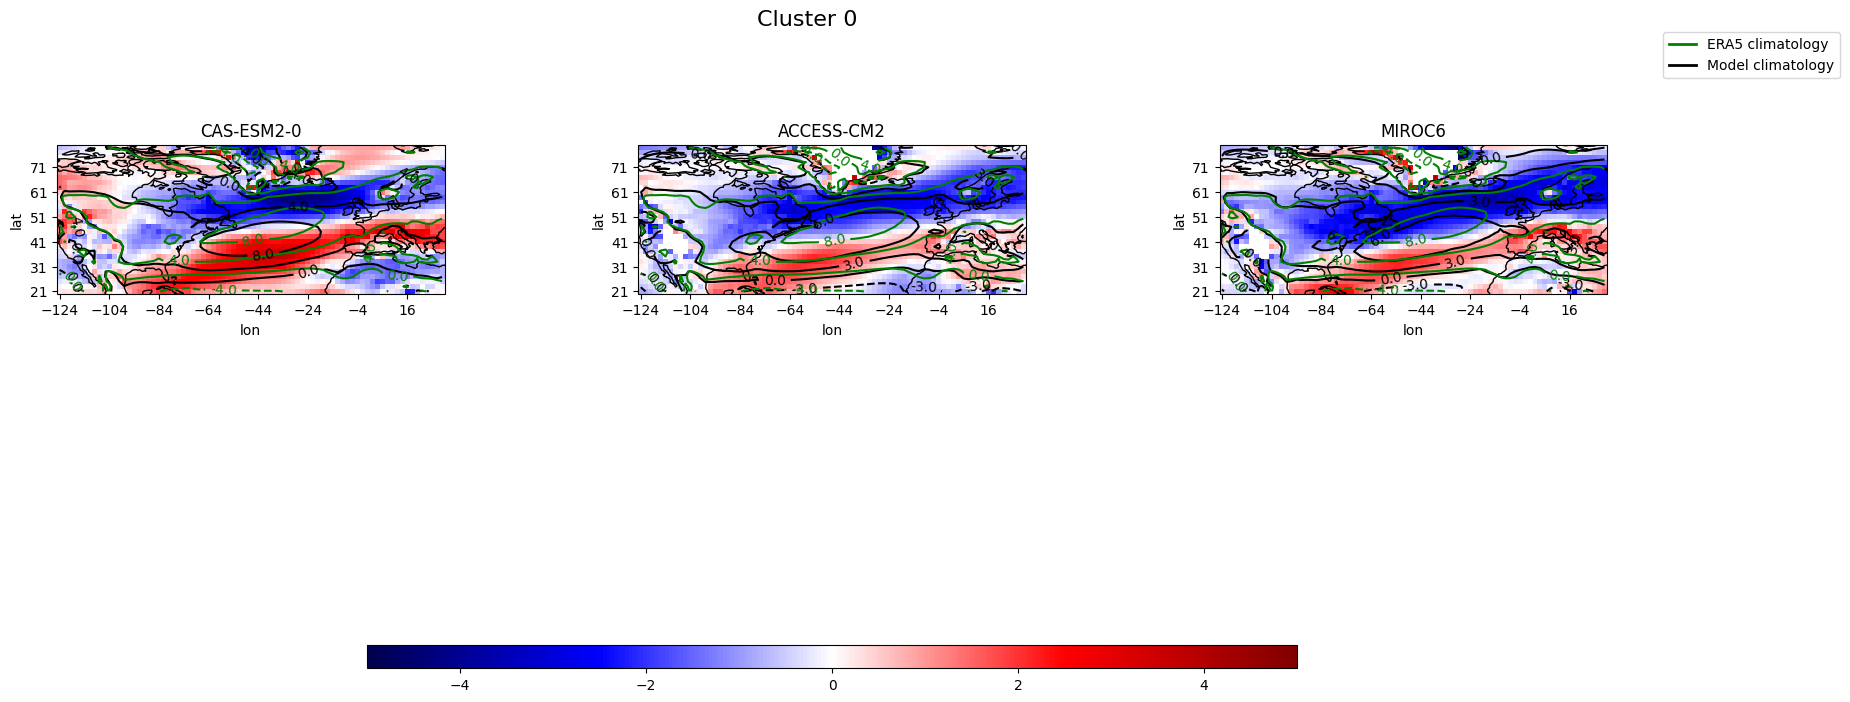

In [56]:
plot_atmos = plot_bias_atmos((int(len(list_cluster0_new)/3)+1),3,(20,8),-5,5,list_cluster0_new,models_atmos,era_na_seas_mean,'Cluster 0','atmos_cluster0_new.pdf')

Cluster 1

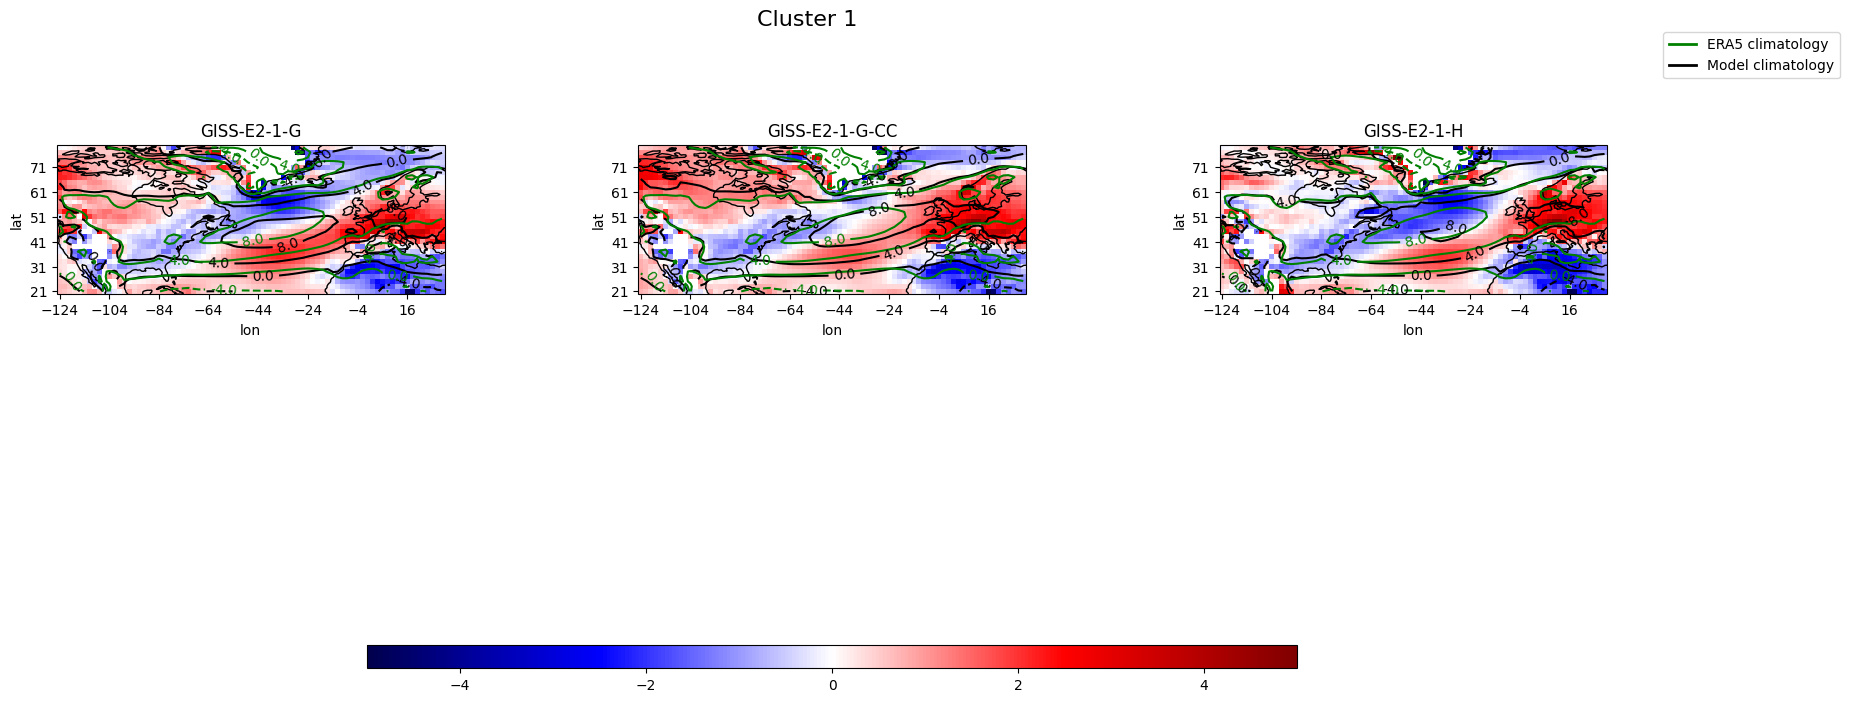

In [57]:
plot_atmos = plot_bias_atmos((int(len(list_cluster1_new)/3)+1),3,(20,8),-5,5,list_cluster1_new,models_atmos,era_na_seas_mean,'Cluster 1','atmos_cluster1_new.pdf')

Cluster 2

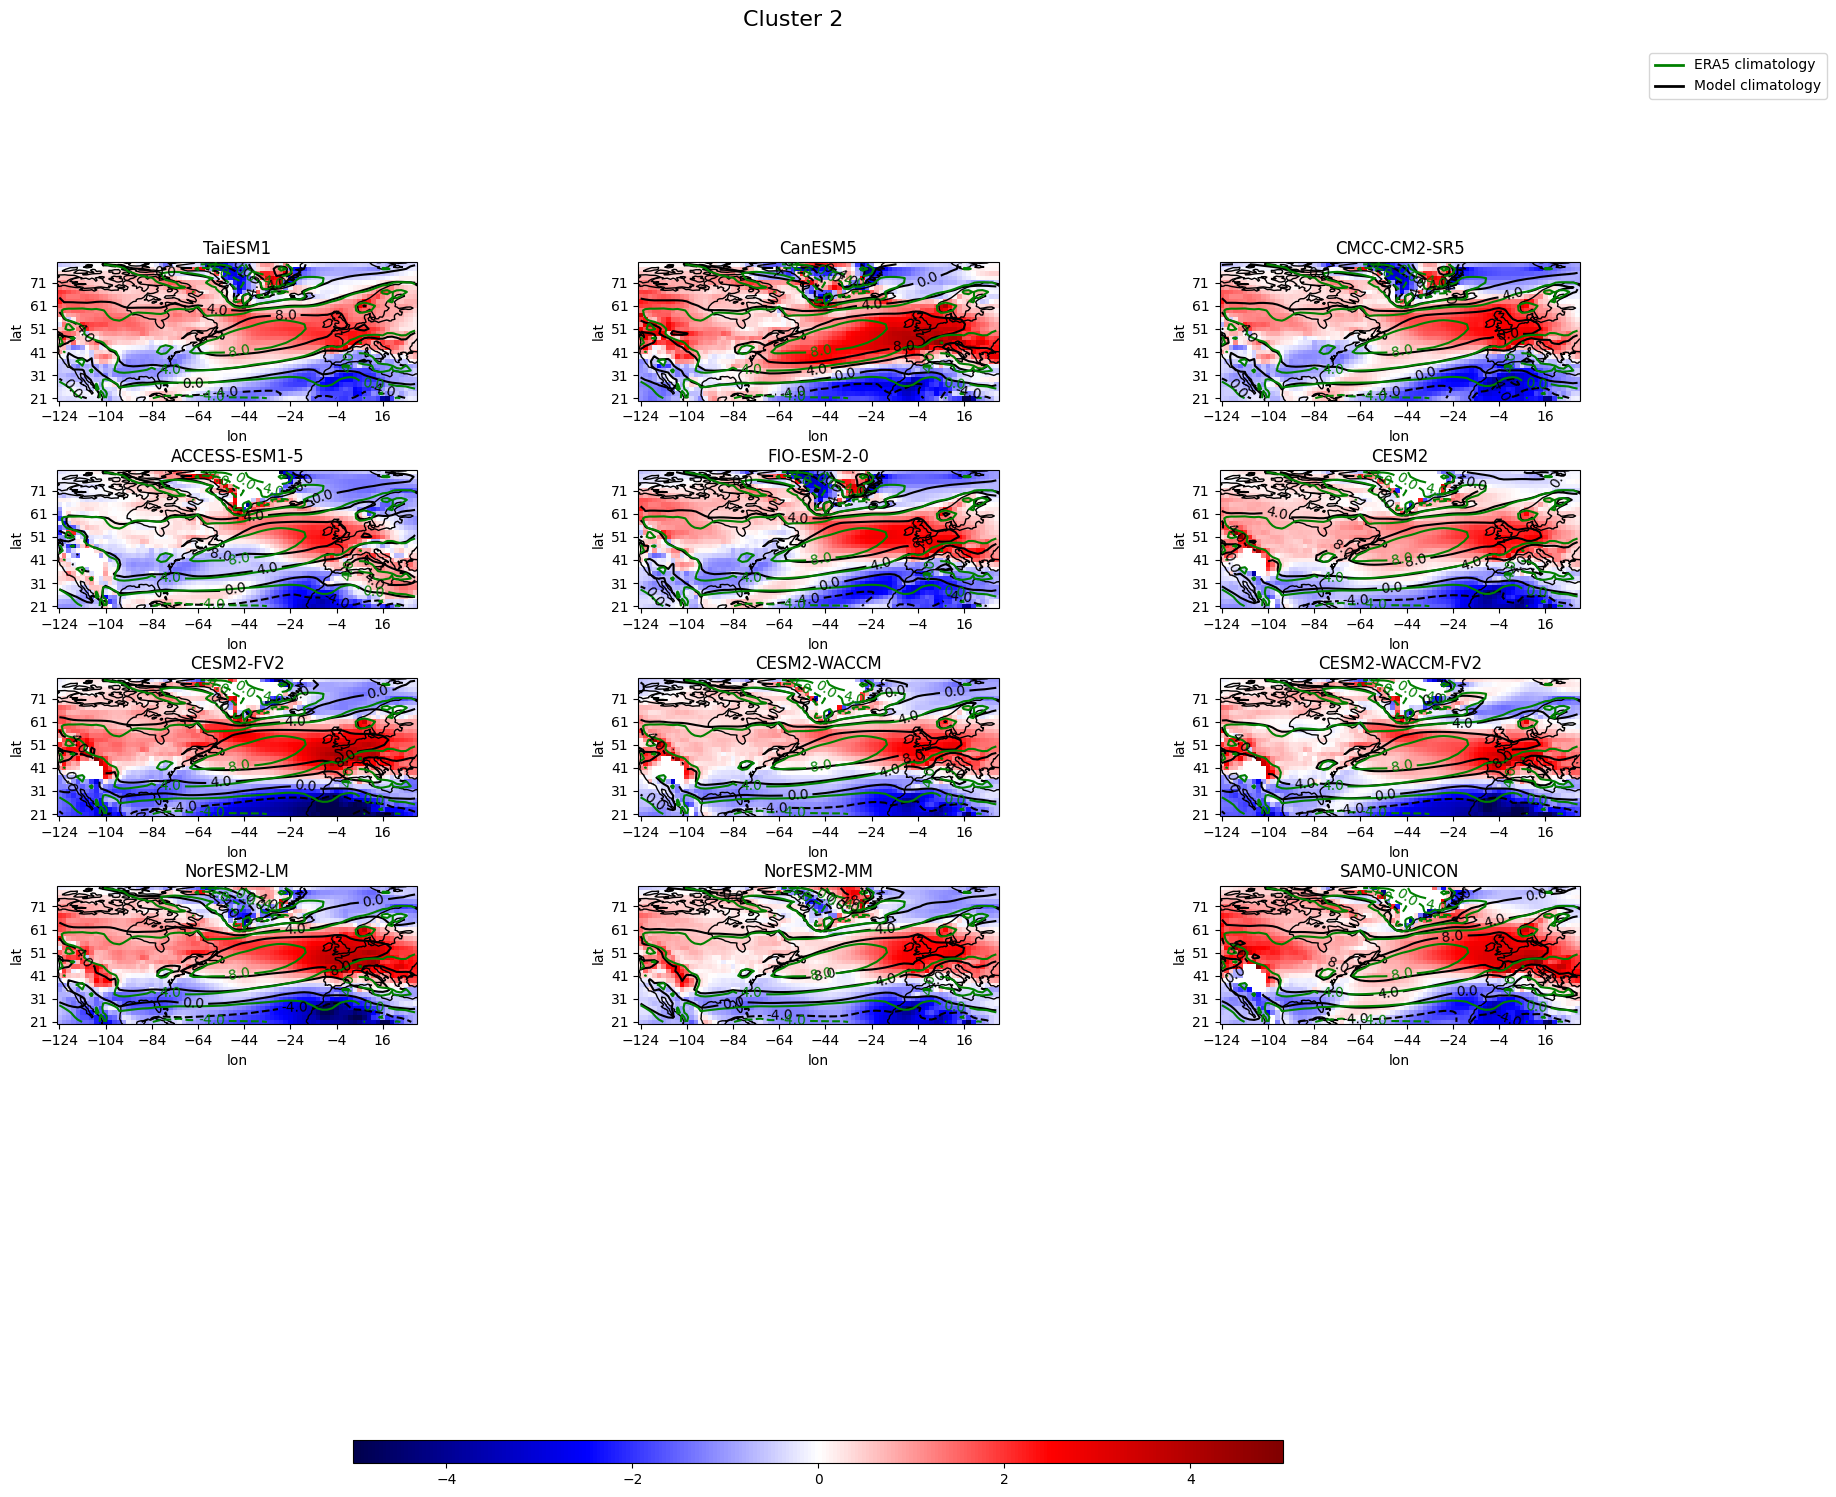

In [58]:
plot_atmos = plot_bias_atmos((int(len(list_cluster2_new)/3)+1),3,(20,18),-5,5,list_cluster2_new,models_atmos,era_na_seas_mean,'Cluster 2','atmos_cluster2_new.pdf')

Cluster 3

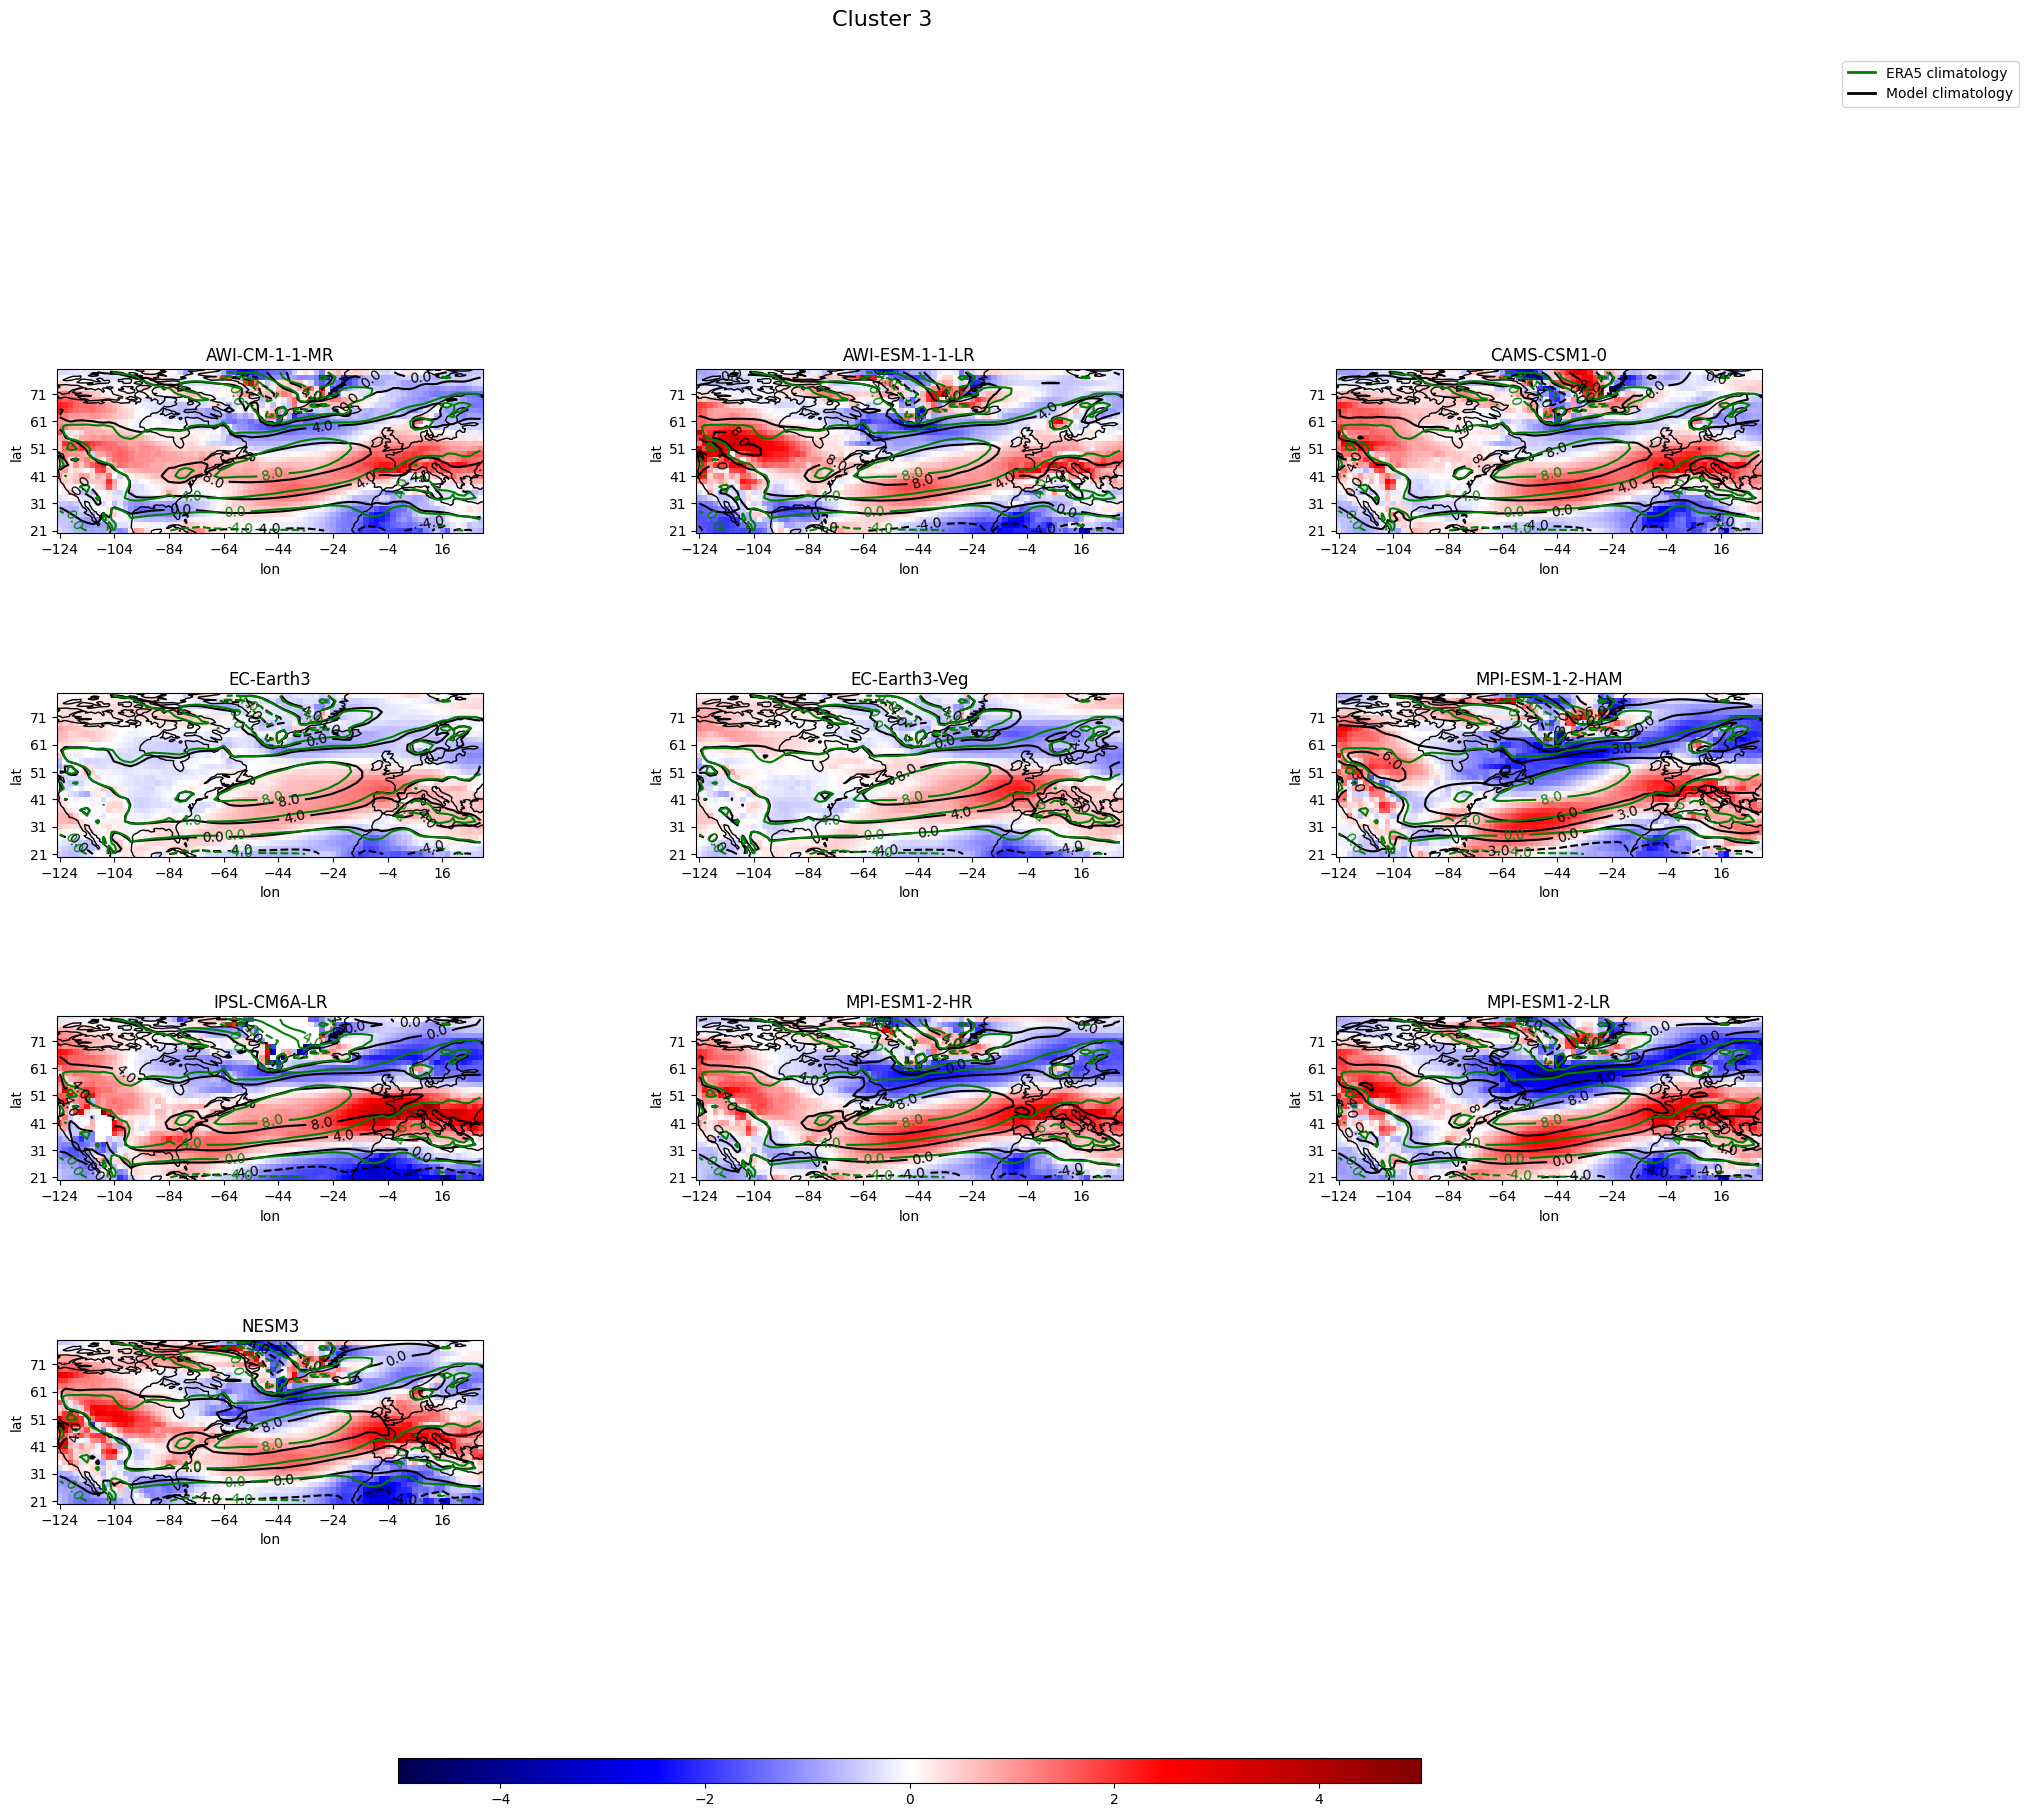

In [59]:
plot_atmos = plot_bias_atmos((int(len(list_cluster3_new)/3)+1),3,(22,22),-5,5,list_cluster3_new,models_atmos,era_na_seas_mean,'Cluster 3','atmos_cluster3_new.pdf')

Cluster 4

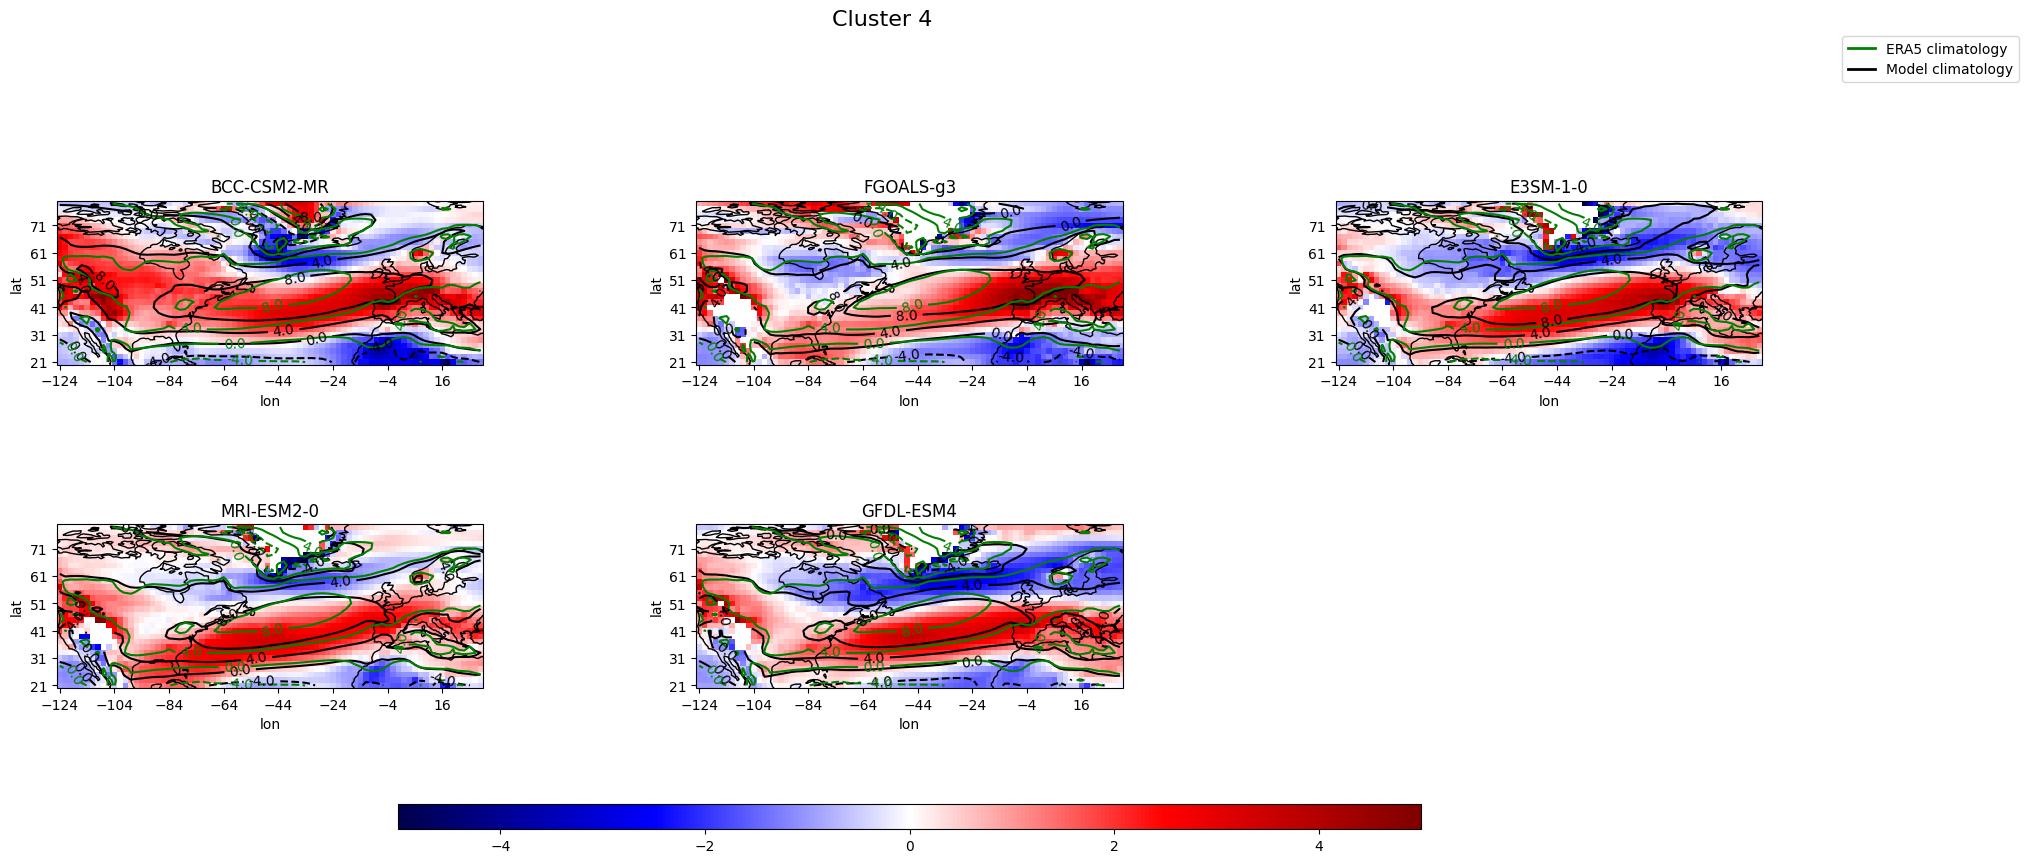

In [60]:
plot_atmos = plot_bias_atmos((int(len(list_cluster4_new)/3)+1),3,(22,10),-5,5,list_cluster4_new,models_atmos,era_na_seas_mean,'Cluster 4','atmos_cluster4_new.pdf')

Cluster 5

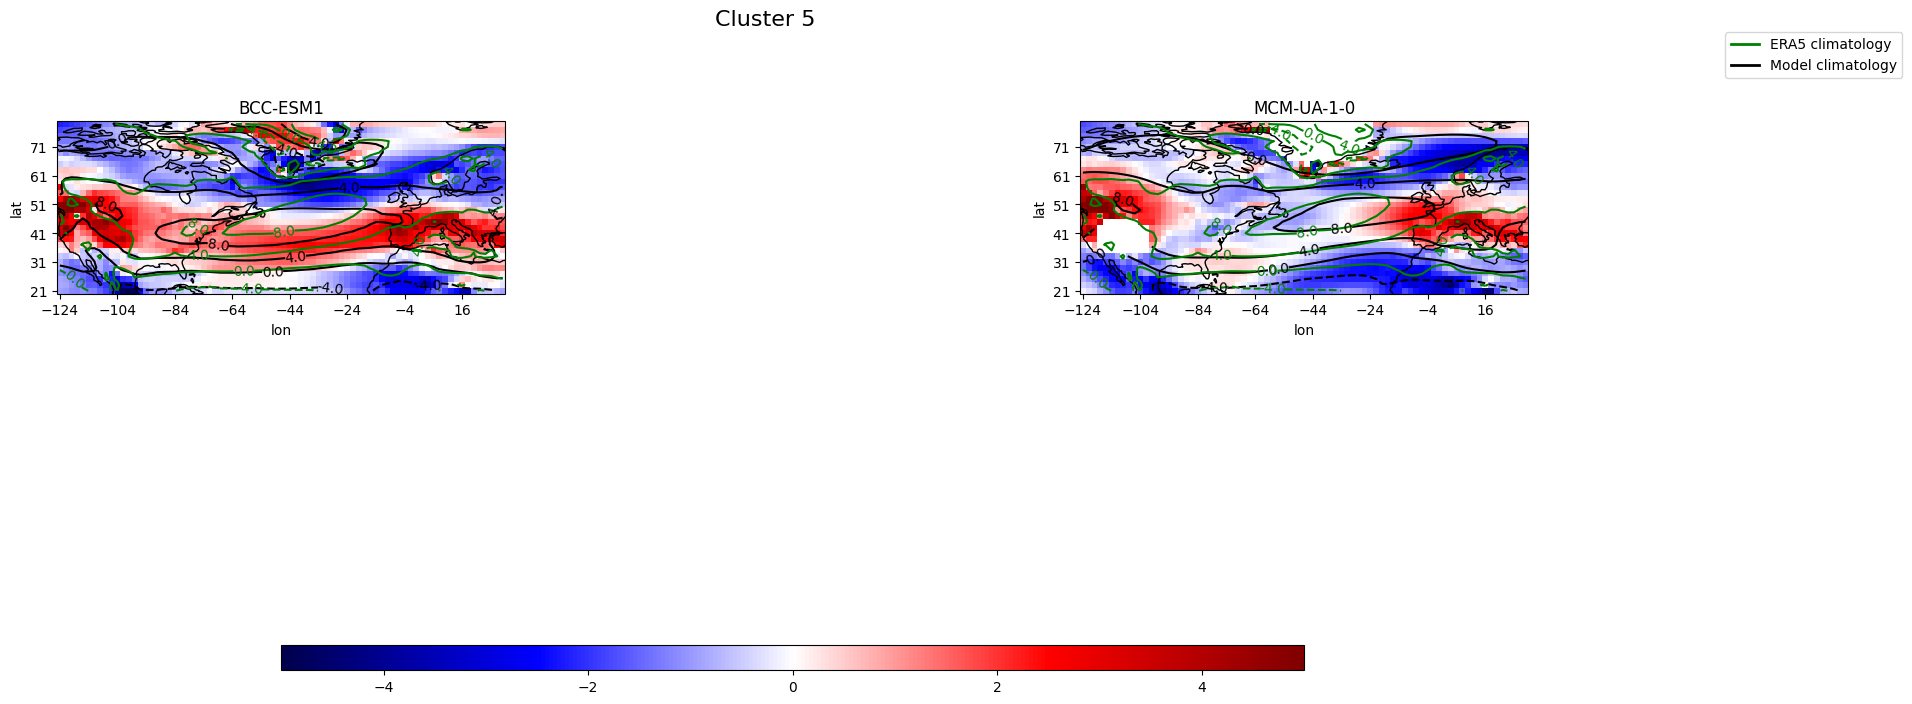

In [61]:
plot_atmos = plot_bias_atmos((int(len(list_cluster5_new)/2)+1),2,(22,8),-5,5,list_cluster5_new,models_atmos,era_na_seas_mean,'Cluster 5','atmos_cluster5_new.pdf')

Cluster medi

In [62]:
def plot_6_mean_cluster_atmos(list_4_clusters, dataset_seas_mean, fig_size, name_dict, v_min, v_max, title_plot, title_pdf):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=fig_size, subplot_kw={"projection": ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Aggiungo spazi verticali tra le subplots
    
    for j in range(len(list_4_clusters)):  # ciclo su tutti i 6 cluster medi
        sum_bias = 0
        for i in range(len(list_4_clusters[j])):  # ciclo sui modelli del cluster j-esimo
            model_name = list_4_clusters[j][i]
            sum_bias += name_dict[model_name]['atmos North Atlantic bias DJF']
        
        # Calcolo del valor medio
        mean_bias_atmos = sum_bias / len(list_4_clusters[j])
        
        # Indicizzazione
        k = j // 3  # indice per le righe
        l = j % 3  # indice per le colonne
        
        plot_mod = ax[k, l].pcolormesh(mean_bias_atmos[0].lon, mean_bias_atmos[0].lat, mean_bias_atmos[0], vmin=v_min, vmax=v_max, cmap='seismic')
        
        data_era = dataset_seas_mean[4]
        contour_era = ax[k, l].contour(data_era[0].lon, data_era[0].lat, data_era[0], colors='g')
        ax[k, l].clabel(contour_era, fmt='%1.1f')
        ax[k, l].coastlines()
        
        # Valori assi
        ax[k, l].set_xticks(np.arange(mean_bias_atmos[0].lon.min(), mean_bias_atmos[0].lon.max(), 20))
        ax[k, l].set_yticks(np.arange(mean_bias_atmos[0].lat.min(), mean_bias_atmos[0].lat.max(), 10))
        ax[k, l].set_xlabel('longitude(deg)')
        ax[k, l].set_ylabel('latitude(deg)')
        ax[k, l].set_title(f'Cluster {j}', fontsize=16, y=1.02)
    
    # Creazione di un oggetto Line2D per la legenda
    green_line = Line2D([0], [0], color='green', lw=2, label='ERA5 climatology')
    
    # Aggiungo la legenda al plot
    fig.legend(handles=[green_line], loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=1)
    
    # Barra del colore
    fig.colorbar(plot_mod, ax=ax.ravel().tolist(), orientation='horizontal', shrink=0.6, aspect=40).set_label('Zonal wind(m/s)')
    
    # Titolo
    fig.suptitle(title_plot, fontsize=16, y=1.02)
    
    # Salva il plot come PDF
    fig.savefig(title_pdf, format='pdf')


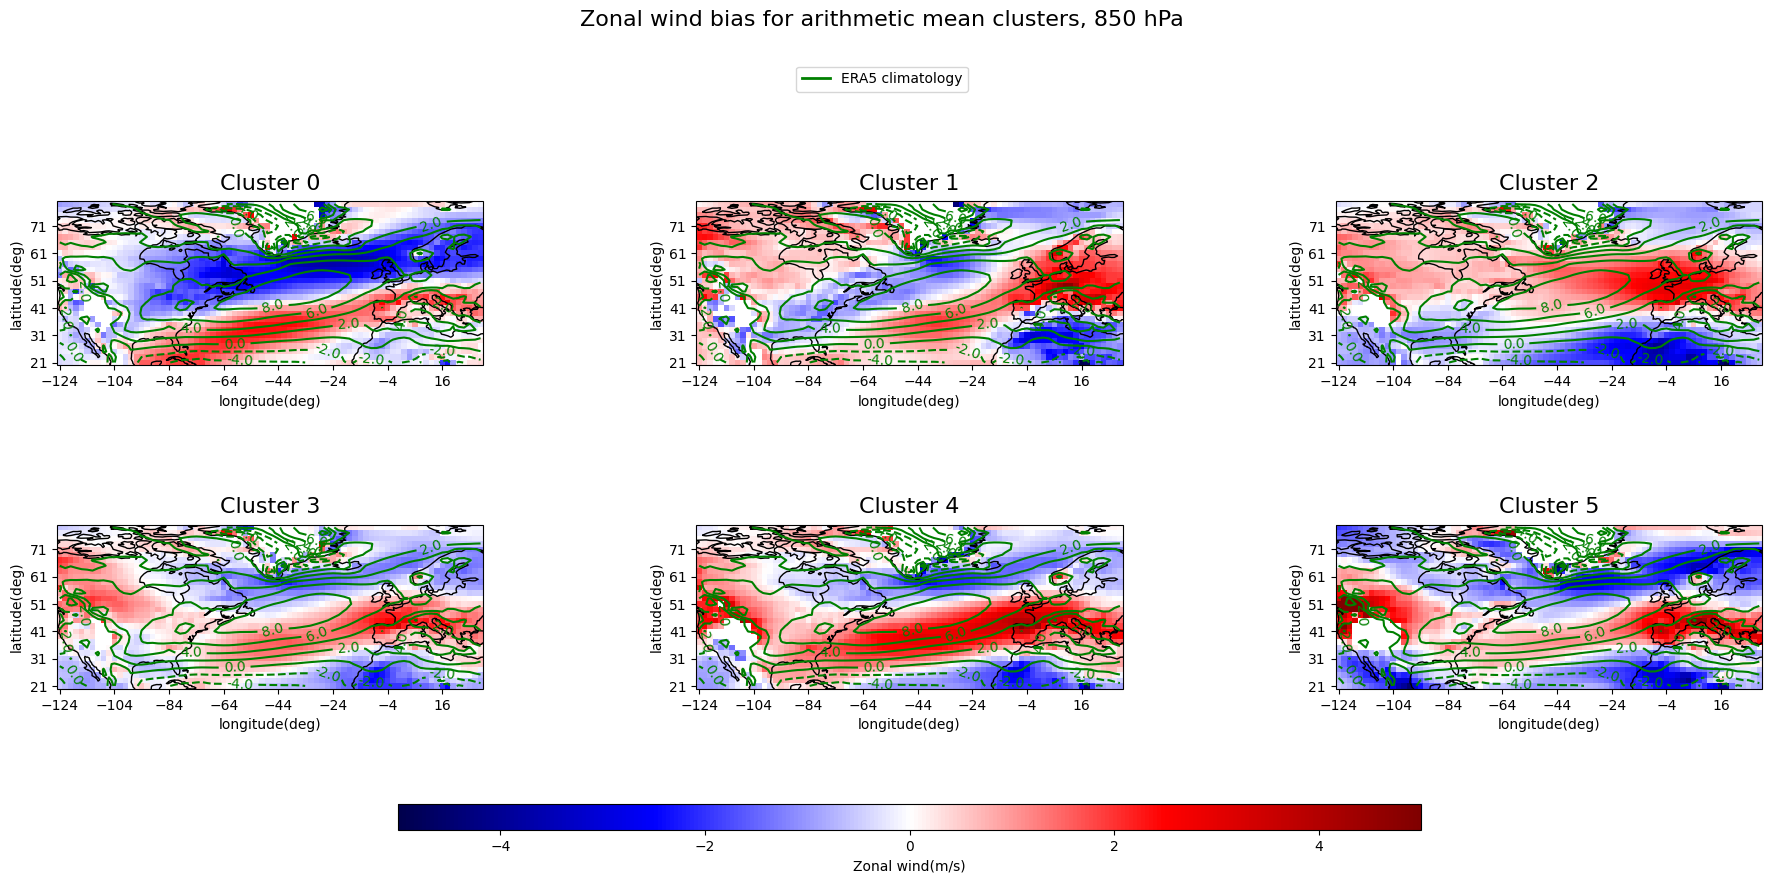

In [63]:
plot_6_mean_cluster_atmos(list_4_clusters_new,era_na_seas_mean,(22,10),models_atmos,-5,5,'Zonal wind bias for arithmetic mean clusters, 850 hPa','cluster_mean_atmos_new.pdf')

In [64]:
#plot_5_mean_cluster_atmos(list_4_clusters_new,era_na_seas_mean,(12,8),models_atmos,-5,5,'Zonal wind bias for arithmetic mean clusters, 850 hPa','cluster_mean_atmos_new.pdf')

Cluster medi tos

In [65]:
def plot_6_mean_cluster_tos(list_4_clusters,dataset_seas_mean,fig_size,name_dict,v_min,v_max,title_plot,title_pdf): #funzione per il plot dei 5 cluster medi di tos
    fig,ax = plt.subplots(nrows=2,ncols=3,figsize=fig_size,subplot_kw={"projection": ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Aggiungo spazi verticali tra le subplots
    #calcolo il valor medio
    for j in range(len(list_4_clusters)): #ciclo su tutti i 4 cluster medi
        #Inizializzo sum_bias per il calcolo della media di tos
        sum_bias = 0
        for i in range(len(list_4_clusters[j])): #ciclo sui modelli del cluster j-esimo
            model_name = list_4_clusters[j][i]
            sum_bias = sum_bias + name_dict[model_name]['North Atlantic bias DJF']
        #valor medio
        mean_bias_tos = sum_bias / len(list_4_clusters[j])
        mean_bias_tos = mean_bias_tos.assign_coords(lon=(np.where(mean_bias_tos.lon >= 280, mean_bias_tos.lon - 360, mean_bias_tos.lon))) #metto i valori negativi di lon per mean_bias
        #plot
        # Indicizzazione
        k = j // 3  # indice per le righe
        l = j % 3  # indice per le colonne
        plot_mod = ax[k,l].pcolormesh(mean_bias_tos.lon,mean_bias_tos.lat,mean_bias_tos,vmin=v_min, vmax=v_max,cmap='seismic')  #trasformazione cartografica = lonxlat
        data_esa = dataset_seas_mean[4]
        contour_esa = ax[k, l].contour(data_esa.lon, data_esa.lat, data_esa, colors='g')
        ax[k,l].clabel(contour_esa, fmt='%1.1f')
        ax[k,l].coastlines() #gca = get current axis
        #valori assi            
        ax[k,l].set_xticks(np.arange(mean_bias_tos.lon.min(),mean_bias_tos.lon.max(), 20))
        ax[k,l].set_yticks(np.arange(mean_bias_tos.lat.min(),mean_bias_tos.lat.max(), 10))
        ax[k,l].set_ylabel('latitude(deg)')
        ax[k,l].set_xlabel('longitude(deg)')
        ax[k,l].set_title(f'Cluster {j}', fontsize=16, y=1.02)
    # Creazione di un oggetto Line2D per la legenda
    green_line = Line2D([0], [0], color='green', lw=2, label='ESA-CCI climatology')  
    # Aggiungo la legenda al plot
    fig.legend(handles=[green_line],loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=1) 
    # Titolo
    fig.colorbar(plot_mod, ax=ax, orientation='horizontal', shrink=0.6, aspect=40).set_label('SST(°C)')
    fig.suptitle(title_plot, fontsize=16, y=1.02)
    fig.savefig(title_pdf, format='pdf')


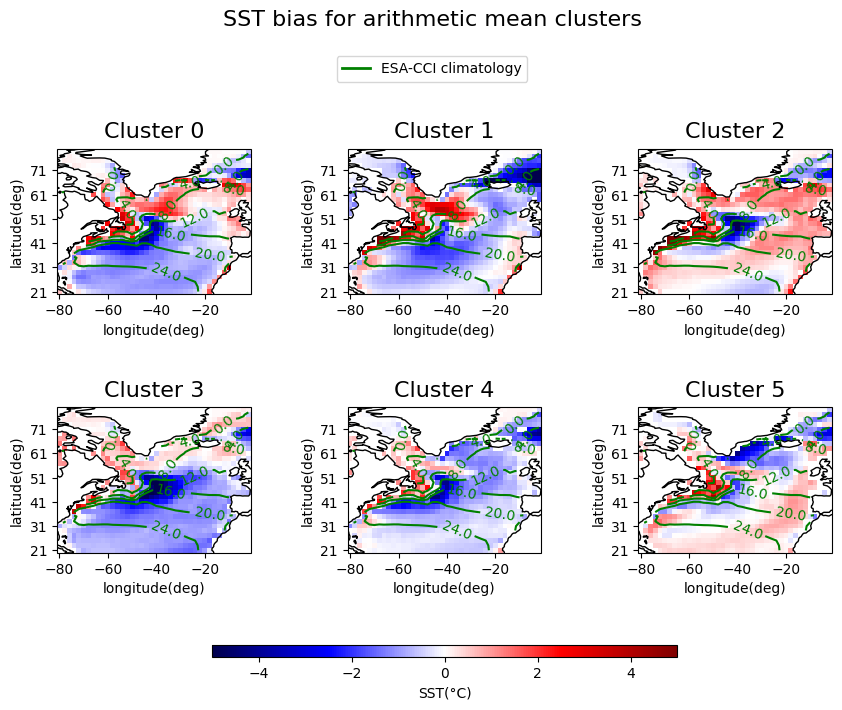

In [66]:
plot_6_mean_cluster_tos(list_4_clusters_new,esa_na_seas_mean_tos,(10,8),models,-5,5,'SST bias for arithmetic mean clusters','cluster_mean_tos_new.pdf')

Cluster medi zonmean

In [69]:
def plot_6_mean_cluster_zonmean(list_4_clusters, dataset_seas_mean, fig_size, name_dict, v_min, v_max, title_plot, title_pdf): #plot dei 5 cluster medi di zonmean    
    fig,ax = plt.subplots(nrows=2,ncols=3,figsize=fig_size)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Aggiungo spazi verticali tra le subplots
    #calcolo il valor medio
    for j in range(len(list_4_clusters)): # ciclo su tutti i 5 cluster medi
        #Inizializzo sum_zonmean per il calcolo della media di zonmean
        sum_zonmean = 0
        for i in range(len(list_4_clusters[j])):  # ciclo sui modelli del cluster j-esimo
            model_name = list_4_clusters[j][i]
            zonmean = name_dict[model_name]['zonmean bias DJF']
            zonmean = zonmean.assign_coords({"plev" : zonmean.plev.round()}) #arrotondo in modo tale che i livelli di pressione siano gli stessi per ogni modello
            sum_zonmean = sum_zonmean + zonmean
        #valor medio
        mean_zonmean = sum_zonmean / len(list_4_clusters[j])
        # Plot
        # Indicizzazione
        k = j // 3  # indice per le righe
        l = j % 3  # indice per le colonne        
        plot_mod = mean_zonmean.plot(vmin=v_min, vmax=v_max, cmap='seismic', ax=ax[k,l], add_colorbar=False)
        data_era = dataset_seas_mean[4]
        contour_era = data_era.sel(lon=0).plot.contour(ax=ax[k,l],colors='g')
        ax[k,l].clabel(contour_era, fmt='%1.1f')
        ax[k,l].set_xlabel('latitude(deg)')
        ax[k,l].set_ylabel('plev(Pa)')
        ax[k,l].invert_yaxis()
        # Titolo
        ax[k,l].set_title(f'Cluster {j}', fontsize=16, y=1.02)
   
    # Creazione di un oggetto Line2D per la legenda
    green_line = Line2D([0], [0], color='green', lw=2, label='ERA5 climatology')     
    # Aggiungo la legenda al plot
    fig.legend(handles=[green_line],loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=1)
    # Barra del colore
    fig.colorbar(plot_mod, ax=ax, orientation='horizontal', shrink=0.6, aspect=40).set_label('Zonal wind(m/s)')         
    # Titolo
    fig.suptitle(title_plot, fontsize=16, y=1.02)
    fig.savefig(title_pdf, format='pdf')

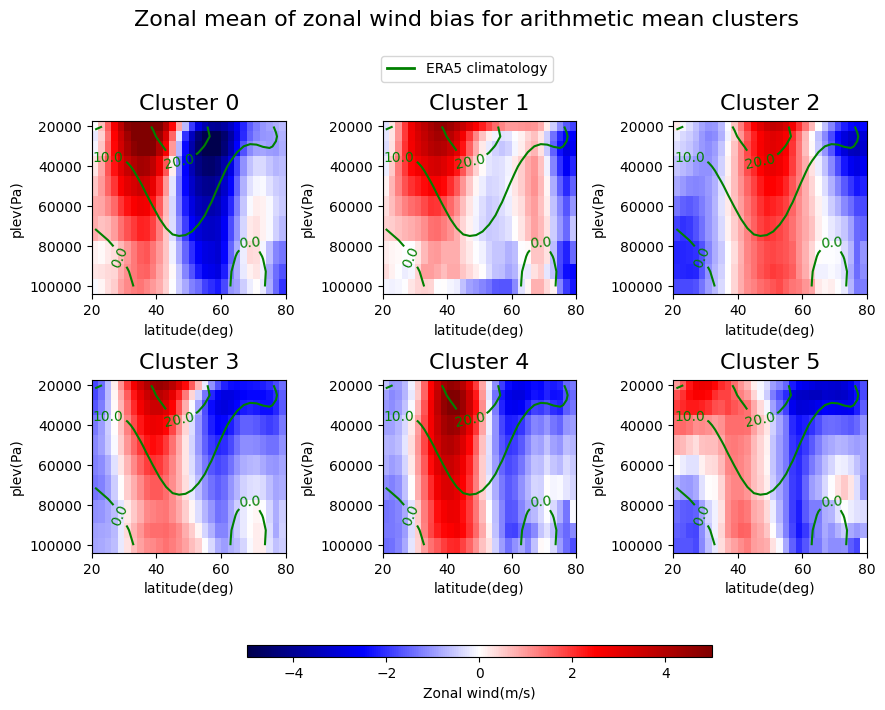

In [72]:
plot_6_mean_cluster_zonmean(list_4_clusters_new, era_seas_mean, (10,8), models_zonmean, -5, 5, 'Zonal mean of zonal wind bias for arithmetic mean clusters', 'cluster_mean_zonmean_new.pdf')

Salvo in file pickle

In [73]:
# Salvataggio di models_atmos
with open('models_atmos_new.pkl', 'wb') as file:
    dill.dump(models_atmos, file)
    dill.dump(era_na_seas_mean,file)
    dill.dump(list_4_clusters_new,file)